# Velocity decomposition

In [1]:
import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
from dask.distributed import Client

import xarray as xr
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from oceanpy import define_grid, horizontal_divergence, gradient_wind_from_ssh
from gsw import f, SA_from_SP, p_from_z, geo_strf_dyn_height, grav

import cmocean as cmo

import warnings
warnings.filterwarnings("ignore")

In [2]:
fs_small = 18
fs_large = 20
plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('axes', labelsize=fs_large)
plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
plt.rc('text', usetex=False)

In [3]:
def horizontal_divergence(ds, grid, vel_names=('u', 'v'), delta_names=('dx', 'dy')):

    # interpolated on t-cells
    dudx_t = grid.interp(grid.diff(ds[vel_names[0]], 'X', boundary='extend'), 'Y', boundary='extend') / ds[delta_names[0]]
    dvdy_t = grid.interp(grid.diff(ds[vel_names[1]], 'Y', boundary='extend'), 'X', boundary='extend') / ds[delta_names[1]]

    div_ht = dudx_t + dvdy_t

    # interpolated on u-cells
    div_hu = grid.interp(grid.interp(div_ht, 'X', boundary='extend'), 'Y', boundary='extend')
    
    div_hu.name = 'div_hu'
    div_hu.attrs['long_name'] = r'$\nabla_H \cdot {\bf u}$'
    
    return div_hu

def relative_vorticity(ds, grid, vel_names=('u', 'v'), delta_names=('dx', 'dy')):

    # interpolated on t-cells
    dvdx_t = grid.interp(grid.diff(ds[vel_names[1]], 'X', boundary='extend'), 'Y', boundary='extend') / ds[delta_names[0]]
    dudy_t = grid.interp(grid.diff(ds[vel_names[0]], 'Y', boundary='extend'), 'X', boundary='extend') / ds[delta_names[1]]

    zeta_t = dvdx_t - dudy_t

    # interpolated on u-cells
    zeta_u = grid.interp(grid.interp(zeta_t, 'X', boundary='extend'), 'Y', boundary='extend')

    zeta_u.name = 'zeta'
    
    return zeta_u


In [4]:
def vortex_stretching(ds, grid, vel_names=('u', 'v'), delta_names=('dx', 'dy')):

    # interpolate velocity gradients on t-cells
    dudx_t = grid.interp(grid.diff(ds[vel_names[0]], 'X', boundary='extend'), 'Y', boundary='extend') / ds[delta_names[0]]
    dvdy_t = grid.interp(grid.diff(ds[vel_names[1]], 'Y', boundary='extend'), 'X', boundary='extend') / ds[delta_names[1]]

    # horizontal divergence
    div_ht = dudx_t + dvdy_t
    
    # Coriolis parameter
    fcor,_ = xr.broadcast(f(ds.v.yu_ocean), ds.v.xu_ocean)

    # interpolate horizontal divergence to u-cells
    div_hu = grid.interp(grid.interp(div_ht, 'X', boundary='extend'), 'Y', boundary='extend')
    
    # vortex stretching term
    fdwdz = - fcor * div_hu
    
    # add attributes
    fdwdz.name = 'fdwdz'
    fdwdz.attrs['long_name'] = r'Vortex stretching, $-f\frac{\partial w}{\partial z}$'
    
    return fdwdz

In [5]:
def adv_relative_vorticity(ds, grid):

    # interpolate relative vorticity gradients on t-cells
    dzetadx_t = grid.interp(grid.diff(ds.zeta, 'X', boundary='extend'), 'Y', boundary='extend') / ds.dxt
    dzetady_t = grid.interp(grid.diff(ds.zeta, 'Y', boundary='extend'), 'X', boundary='extend') / ds.dyt

    # interpolate velocities to t-cells
    u_t = grid.interp(grid.interp(ds.u, 'X', boundary='extend'), 'Y', boundary='extend')
    v_t = grid.interp(grid.interp(ds.v, 'X', boundary='extend'), 'Y', boundary='extend')
    
    # advection of relative vorticity
    ugradzeta_t = (u_t * dzetadx_t) + (v_t * dzetady_t)

    # interpolated to u-cells
    ugradzeta = grid.interp(grid.interp(ugradzeta_t, 'X', boundary='extend'), 'Y', boundary='extend')

    # add attributes
    ugradzeta.name = 'ugradzeta'
    ugradzeta.attrs['long_name'] = r'Advection of relative vorticity, ${\bf u} \cdot \nabla\zeta$'
    
    return ugradzeta


In [6]:
def adv_planetary_vorticity(ds, grid):

    # Coriolis parameter
    fcor,_ = xr.broadcast(f(ds.yu_ocean), ds.xu_ocean)
    
    # meridional gradient interpolated on t-cells
    beta = grid.interp(grid.diff(fcor, 'Y', boundary='extend'), 'X', boundary='extend') / ds.dyt
    
    # interpolated on u-cells
    beta = grid.interp(grid.interp(beta, 'X', boundary='extend'), 'Y', boundary='extend')
    
    # advection of planetary vorticity
    betav = beta * ds.v
    
    # add attributes
    betav.name = 'betav'
    betav.attrs['long_name'] = 'Advection of planetary vorticity, $\beta v$'
    # beta.name = 'beta'
    # beta.attrs['long_name'] = 'Meridional gradient of the Coriolis parameter'
    
    return betav#, beta


In [7]:
def vorticity_tendency(ds):
    
    # local time derivative
    dzetadt = ds.zeta.chunk({'time': -1}).differentiate('time', datetime_unit='s')
    
    # add attributes
    dzetadt.name = 'dzetadt'
    dzetadt.attrs['long_name'] = 'Vorticity tendency, $\frac{\partial \zeta}{\partial t}$'
    
    return dzetadt

In [8]:
def bottom_pressure_torque(ds, grid):

    # Coriolis parameter
    fcor,_ = xr.broadcast(f(ds.yu_ocean), ds.xu_ocean)
    
    # topography gradient interpolated on u-cells
    dzbdx_u = grid.interp(grid.diff(ds.ht, 'X', boundary='extend'), 'Y', boundary='extend') / ds.dxu
    dzbdy_u = grid.interp(grid.diff(ds.ht, 'Y', boundary='extend'), 'X', boundary='extend') / ds.dyu

    # advection of relative vorticity
    last_cell = kmu_lim.copy()
    last_cell.values = last_cell.values.astype(int) - 3
    bpt = - fcor * ((ds.u.isel(st_ocean=last_cell) * dzbdx_u) + (ds.v.isel(st_ocean=kmu_lim) * dzbdy_u))
    
    return bpt

In [9]:
def stress_curl(ds, grid, stress_names=('tau_x', 'tau_y')):
    
    # interpolated on t-cells
    dtauydx_t = grid.interp(grid.diff(ds[stress_names[1]], 'X', boundary='extend'), 'Y', boundary='extend') / ds.dxt
    dtauxdy_t = grid.interp(grid.diff(ds[stress_names[0]], 'Y', boundary='extend'), 'X', boundary='extend') / ds.dyt

    curl_tau_t = dtauydx_t - dtauxdy_t

    # interpolated on u-cells
    curl_tau = grid.interp(grid.interp(curl_tau_t, 'X', boundary='extend'), 'Y', boundary='extend')
    
    curl_tau.name = 'curl_tau'

    return curl_tau

## Load data

In [10]:
database = '/g/data/ik11/databases/cosima_master.db'
session = cc.database.create_session(db=database)

expt = '01deg_jra55v140_iaf'

In [11]:
client = Client(n_workers=8, memory_limit='180GB')
client

2023-01-25 16:55:57,028 - distributed.worker_memory - WARNING - Ignoring provided memory limit 180GB due to system memory limit of 44.92 GiB
2023-01-25 16:55:57,034 - distributed.worker_memory - WARNING - Ignoring provided memory limit 180GB due to system memory limit of 44.92 GiB
2023-01-25 16:55:57,039 - distributed.worker_memory - WARNING - Ignoring provided memory limit 180GB due to system memory limit of 44.92 GiB
2023-01-25 16:55:57,043 - distributed.worker_memory - WARNING - Ignoring provided memory limit 180GB due to system memory limit of 44.92 GiB
2023-01-25 16:55:57,047 - distributed.worker_memory - WARNING - Ignoring provided memory limit 180GB due to system memory limit of 44.92 GiB
2023-01-25 16:55:57,052 - distributed.worker_memory - WARNING - Ignoring provided memory limit 180GB due to system memory limit of 44.92 GiB
2023-01-25 16:55:57,056 - distributed.worker_memory - WARNING - Ignoring provided memory limit 180GB due to system memory limit of 44.92 GiB
2023-01-25 16

<Client: 'tcp://127.0.0.1:46583' processes=8 threads=16, memory=359.38 GiB>

In [12]:
# time limits of dataset
start, end = '1997-04-01', '1997-04-30'

# data output frequency
freq = '1 daily'

In [13]:
# sl = cc.querying.getvar(expt=expt, variable='sea_level', session=session, frequency=freq, start_time='1958-01-01', end_time='2019-01-01')

In [14]:
sl = cc.querying.getvar(expt=expt, variable='sea_level', session=session, frequency=freq, start_time=start, end_time=end)
u = cc.querying.getvar(expt=expt, variable='u', session=session, frequency=freq, start_time=start, end_time=end)
v = cc.querying.getvar(expt=expt, variable='v', session=session, frequency=freq, start_time=start, end_time=end)
wt = cc.querying.getvar(expt=expt, variable='wt', session=session, frequency=freq, start_time=start, end_time=end)

ht = cc.querying.getvar(expt=expt, variable='ht', session=session, frequency='static', n=1)

# load coordinates
dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)
dzt = cc.querying.getvar(expt=expt, variable='dzt', session=session, frequency='1 monthly', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

area_t = cc.querying.getvar(expt=expt, variable='area_t', session=session, frequency='static', n=1)
area_u = cc.querying.getvar(expt=expt, variable='area_u', session=session, frequency='static', n=1)

kmu = cc.querying.getvar(expt=expt, variable='kmu', session=session, frequency='static', n=1)
kmt = cc.querying.getvar(expt=expt, variable='kmt', session=session, frequency='static', n=1)


In [15]:
# wind stress
tau_x = cc.querying.getvar(expt=expt, variable='tau_x', session=session, frequency='1 monthly', start_time=start, end_time=end)
tau_y = cc.querying.getvar(expt=expt, variable='tau_y', session=session, frequency='1 monthly', start_time=start, end_time=end)

# bottom stress
bmf_u = cc.querying.getvar(expt=expt, variable='bmf_u', session=session, frequency='1 monthly', start_time=start, end_time=end)
bmf_v = cc.querying.getvar(expt=expt, variable='bmf_v', session=session, frequency='1 monthly', start_time=start, end_time=end)

# bottom pressure
pbot_t = cc.querying.getvar(expt=expt, variable='pbot_t', session=session, frequency='1 monthly', start_time=start, end_time=end)

# potential density
# pot_rho = cc.querying.getvar(expt=expt, variable='pot_rho_0', session=session, frequency='1 monthly', start_time=start, end_time=end)

In [16]:
# a.time_bounds

In [17]:
u_monthly = cc.querying.getvar(expt=expt, variable='u', session=session, frequency='1 monthly', start_time=start, end_time=end)
v_monthly = cc.querying.getvar(expt=expt, variable='v', session=session, frequency='1 monthly', start_time=start, end_time=end)
wt_monthly = cc.querying.getvar(expt=expt, variable='wt', session=session, frequency='1 monthly', start_time=start, end_time=end)

In [18]:
temp = cc.querying.getvar(expt=expt, variable='temp', session=session, frequency=freq, start_time=start, end_time=end)
salt = cc.querying.getvar(expt=expt, variable='salt', session=session, frequency=freq, start_time=start, end_time=end)
geolat_t = cc.querying.getvar(expt,'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt,'geolon_t', session=session, n=1)

## Select region of interest

In [19]:
# location limits of dataset
lon_lim = slice(-224.2, -212) #230
lat_lim = slice(-53.5, -47.5)
meander_period = slice('1997-02-15', '1997-05-31')
flex_period = slice('1997-04-10', '1997-04-25')
monthly_mean = slice('1997-04-01', '1997-04-30')

In [20]:
sl_lim = sl.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
u_lim = u.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
v_lim = v.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
wt_lim = wt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

ht_lim = ht.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

# coordinates
dxt_lim = dxt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
dzt_lim = dzt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim).isel(time=1)
dzt_lim.name = 'dst'

dxu_lim = dxu.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)

areat_lim = area_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
areau_lim = area_u.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)

kmu_lim = kmu.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
kmt_lim = kmt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

# for last cell
kmu_lim.values = kmu_lim.values.astype(int) - 1
kmt_lim.values = kmt_lim.values.astype(int) - 1

In [21]:
# lon_lim = slice(-224, -212.5)
# lat_lim = slice(-53.5, -47.5)

temp_sel = temp.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, time=meander_period)
salt_sel = salt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, time=meander_period)

lat_t = geolat_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

In [22]:
tau_xlim = tau_x.sel(xu_ocean=lon_lim, yu_ocean=lat_lim, time='1997-04-16')
tau_ylim = tau_y.sel(xu_ocean=lon_lim, yu_ocean=lat_lim, time='1997-04-16')

bmf_ulim = bmf_u.sel(xu_ocean=lon_lim, yu_ocean=lat_lim, time='1997-04-16')
bmf_vlim = bmf_v.sel(xu_ocean=lon_lim, yu_ocean=lat_lim, time='1997-04-16')

pbot_tlim = pbot_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, time='1997-04-16')

u_monthly = u_monthly.sel(xu_ocean=lon_lim, yu_ocean=lat_lim, time='1997-04-16')
v_monthly = v_monthly.sel(xu_ocean=lon_lim, yu_ocean=lat_lim, time='1997-04-16')
wt_monthly = wt_monthly.sel(xt_ocean=lon_lim, yt_ocean=lat_lim, time='1997-04-16')

## Constants

In [23]:
g = 9.81
rho_0 = 1036 # kg/m^3
A_z = 20e-3 # vertical eddy viscosity
p_ref = 0 #1500
p_int = 2500

## Define grid

In [24]:
# define coordinates
coords = {'xt_ocean': None, 'yt_ocean': None, 'st_ocean': None, 'xu_ocean': 0.5, 'yu_ocean': 0.5, 'sw_ocean': -0.5}
distances=('dxt', 'dyt', 'dst', 'dxu', 'dyu')
areas=('area_u', 'area_t')
dims=('X', 'Y', 'S')

coordinates = xr.merge([dxt_lim, dyt_lim, dzt_lim, dxu_lim, dyu_lim, areat_lim, areau_lim, ht_lim])

# define variables
vel = xr.merge([coordinates, sl_lim.sel(time=flex_period),
               u_lim.sel(time=flex_period), v_lim.sel(time=flex_period), 
               wt_lim.sel(time=flex_period)])

# define grid
grid = define_grid(vel, dims, coords, distances, areas, periodic=False)

## Calculate pressure

In [25]:
# https://xgcm.readthedocs.io/en/latest/grid_ufuncs.html
# https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Buoyancy_Geostrophic_shear.html
# pt = xr.apply_ufunc(pdens, ds.so, ds.thetao,
#                     dask='parallelized',
#                     output_dtypes=[ds.so.dtype])

In [26]:
# st_ocean = temp_sel.st_ocean.values
# yt_ocean = temp_sel.yt_ocean.values
# xt_ocean = temp_sel.xt_ocean.values
# time = temp_sel.time.values

# lat_t_3d = lat_t.broadcast_like(coordinates.dst) #np.broadcast_to(lat_t, st_ocean.shape + (lat_t.shape))

# # NOTE: minus before st_ocean is because z is defined upwards and st_ocean is depth defined positive downwards
# z_3d = (-coordinates.st_ocean).broadcast_like(coordinates.dst) #np.broadcast_to(-st_ocean, lat_t_3d.T.shape).T

# p_3d = xr.DataArray(p_from_z(z_3d, lat_t_3d), 
#                         coords = [st_ocean, yt_ocean, xt_ocean], 
#                         dims = ['st_ocean', 'yt_ocean', 'xt_ocean'],
#                         name = 'pressure',
#                         attrs = {'standard_name': 'sea_water_pressure', 'units':'dbar'})
# # p_3d = xr.apply_ufunc(p_from_z, z_3d, lat_t_3d, dask='parallelized', output_dtypes=[hydro.SA.dtype]

# SA = xr.DataArray(SA_from_SP(salt_sel, p_3d, lon_t, lat_t), 
#                   coords = [time, st_ocean, yt_ocean, xt_ocean], 
#                   dims = ['time', 'st_ocean', 'yt_ocean', 'xt_ocean'], 
#                   name = 'SA', 
#                   attrs = {'standard_name': 'sea_water_absolute_salinity', 'units':'g kg-1'})

# CT = temp_sel-273
# CT.name = 'CT'
# CT.attrs.update(units=r'$^\circ$C')

# hydro = xr.merge([SA, CT])
# # hydro['pressure'] = hydro['pressure'].broadcast_like(hydro['SA'])

# # chunks={'time':1, 'st_ocean': 1}
# # hydro = hydro.chunk(chunks)

In [27]:
# # NOTE: minus before geo_strf_dyn_height or deltaD is because of intergrating downwards
# # deltaD = - geo_strf_dyn_height(hydro.SA.values, hydro.CT.values, hydro.pressure.values, p_ref=p_ref, axis=1)
# deltaD = - xr.apply_ufunc(geo_strf_dyn_height, hydro.SA, hydro.CT, p_4d, kwargs={'p_ref': p_ref, 'axis': 1}, dask='parallelized', output_dtypes=[hydro.SA.dtype])
# deltaD.name = 'deltaD'
# deltaD.attrs = {'standard_name': 'dynamic height anomaly', 'units':'m2 s-2'}


# # pressure = p_from_z(z_4d, lat_t_4d, deltaD)
# pressure = xr.apply_ufunc(p_from_z, z_4d, lat_t_4d, deltaD, dask='parallelized', output_dtypes=[deltaD.dtype])



In [28]:
# # NOTE: minus before geo_strf_dyn_height or deltaD is because of intergrating downwards
# deltaD = -xr.DataArray(geo_strf_dyn_height(SA.values, CT.values, np.broadcast_to(p_3d, SA.shape), p_ref=p_ref, axis=1),
#                       coords = [time, st_ocean, yt_ocean, xt_ocean],
#                       dims = ['time', 'st_ocean', 'yt_ocean', 'xt_ocean'],
#                       name = 'deltaD',
#                       attrs = {'standard_name': 'dynamic height anomaly', 'units':'m2 s-2'})

# pressure = xr.DataArray(p_from_z(z_4d, lat_t_4d, deltaD),
#                  coords = [time, st_ocean, yt_ocean, xt_ocean],
#                  dims = ['time', 'st_ocean', 'yt_ocean', 'xt_ocean'],
#                  name = 'pressure',
#                  attrs = {'standard_name': 'sea_water_pressure', 'units':'dbar'})

# # g = gsw.grav(lat_t_3d, pressure)
# # D = deltaD.sel(st_ocean=p_int, method='nearest') / g.sel(st_ocean=p_int, method='nearest')


In [29]:
lat_t_3d = lat_t.broadcast_like(coordinates.dst) #np.broadcast_to(lat_t, st_ocean.shape + (lat_t.shape))
z_3d = (-coordinates.st_ocean).broadcast_like(coordinates.dst) #np.broadcast_to(-st_ocean, lat_t_3d.T.shape).T
p_3d = xr.apply_ufunc(p_from_z, z_3d, lat_t_3d, dask='parallelized', output_dtypes=[z_3d.dtype])
p_3d = p_3d.compute()

# SA = xr.DataArray(SA_from_SP(salt_sel, p_3d, lon_t, lat_t), 
#                   coords = [time, st_ocean, yt_ocean, xt_ocean], 
#                   dims = ['time', 'st_ocean', 'yt_ocean', 'xt_ocean'], 
#                   name = 'SA', 
#                   attrs = {'standard_name': 'sea_water_absolute_salinity', 'units':'g kg-1'})
SA = xr.apply_ufunc(SA_from_SP, salt_sel, p_3d, lon_t, lat_t, dask='parallelized', output_dtypes=[z_3d.dtype])
SA = SA.compute()
SA.name = 'SA'
SA.attrs = {'standard_name': 'sea_water_absolute_salinity', 'units': r'$\mathrm{gkg}^{-1}$'}


CT = temp_sel-273
CT.name = 'CT'
CT.attrs.update(units=r'$^\circ$C')

hydro = xr.merge([SA, CT])
# # chunks={'time':1, 'st_ocean': 1}
# # hydro = hydro.chunk(chunks)

In [30]:
p_4d = p_3d.broadcast_like(hydro.SA)
z_4d = z_3d.broadcast_like(hydro.SA)
lat_t_4d = lat_t_3d.broadcast_like(hydro.SA)

# NOTE: minus before geo_strf_dyn_height or deltaD is because of intergrating downwards
deltaD = - xr.DataArray(geo_strf_dyn_height(SA.values, CT.values, p_4d.values, p_ref=p_ref, axis=1),
                      coords = [hydro.time, hydro.st_ocean, hydro.yt_ocean, hydro.xt_ocean],
                      dims = ['time', 'st_ocean', 'yt_ocean', 'xt_ocean'],
                      name = 'deltaD',
                      attrs = {'standard_name': 'dynamic height anomaly', 'units': r'$\mathrm{m}^2\mathrm{s}^{-2}$'})
# deltaD = - xr.apply_ufunc(geo_strf_dyn_height, hydro.SA, hydro.CT, p_4d, kwargs={'p_ref': p_ref, 'axis': 1}, dask='parallelized', output_dtypes=[hydro.SA.dtype])
# deltaD = deltaD.compute()
# deltaD.name = 'deltaD'

pressure = xr.apply_ufunc(p_from_z, z_4d, lat_t_4d, deltaD, dask='parallelized', output_dtypes=[deltaD.dtype])
pressure = pressure.compute()
pressure.name = 'pressure'
pressure.attrs = {'standard_name': 'sea_water_pressure', 'units':'dbar'}

hydro = xr.merge([hydro, deltaD, pressure])

In [31]:
p_baseline = hydro.pressure.sel(time=meander_period).mean('time')
p_anomalous = hydro.pressure.sel(time=meander_period) - p_baseline

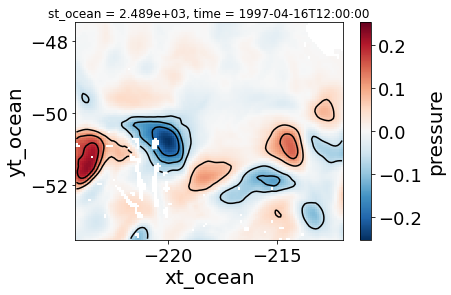

In [32]:
p_anomalous.sel(time='1997-04-16', method='nearest').sel(st_ocean=2500, method='nearest').plot()
p_anomalous.sel(time='1997-04-16', method='nearest').sel(st_ocean=2500, method='nearest').plot.contour(levels=[-0.18, -0.12, -0.06, 0.06, 0.12, 0.18], colors='k', linestyles='solid')

## Geostrophic velocity
- Dynamic height and pressure: http://faculty.washington.edu/luanne/pages/ocean420/notes/Dynamic.pdf
- https://o2.eas.gatech.edu/courses/EAS6305/week5.pdf
- https://essd.copernicus.org/preprints/essd-2021-170/essd-2021-170.pdf

\begin{eqnarray}
    u_g(p) - u_{g,s}(p_0) = -\frac{g}{f}\frac{\partial \Delta D}{\partial y} \\
    v_g(p) - v_{g,s}(p_0) = \frac{g}{f}\frac{\partial \Delta D}{\partial x}
\end{eqnarray}

\begin{eqnarray}
    u_{g,s}(p_0) = -\frac{g}{f}\frac{\partial \eta}{\partial y} \\
    v_{g,s}(p_0) = \frac{g}{f}\frac{\partial \eta}{\partial x}
\end{eqnarray}

$\Delta D$, dynamic height anomaly (positive downwards)

In [33]:
# TODO: optimise function with xarray apply_ufunc
# also in calc geo_strf_dyn_height and p_from_z

# ug, vg = xr.apply_ufunc(geostrophic_velocity_from_TS, ds.so, ds.thetao,
#                     dask='parallelized',
#                     output_dtypes=[ds.so.dtype])

# u = np.diff(geo_strf, axis=laxis) / (ds * f(mid_lat))
def geostrophic_velocity(ds, grid, sea_level='sea_level', stream_func='deltaD', gravity='gu', coriolis='f', delta_names=('dx', 'dy')):

    '''
    calculate geostrophic velocity from level of 'known' motion (e.g. surface)
    '''
    
    # surface geostrophic velocity
    detadx = grid.interp(grid.diff(ds[sea_level], 'X', boundary='extend'), 'Y', boundary='extend') / ds[delta_names[0]]
    detady = grid.interp(grid.diff(ds[sea_level], 'Y', boundary='extend'), 'X', boundary='extend') / ds[delta_names[1]]

    ds['ug_s']= - (ds[gravity].isel(st_ocean=0) / ds[coriolis]) * detady
    ds['vg_s'] = (ds[gravity].isel(st_ocean=0) / ds[coriolis]) * detadx

    ds['ug_s'].name = 'ug_s'
    ds['ug_s'].attrs['standard_name'] = 'surface_geostrophic_eastward_sea_water_velocity'
    ds['ug_s'].attrs['long_name'] = r'$u_g,s$'
    ds['ug_s'].attrs['units'] = r'$\mathrm{ms}^{-1}$'
    
    ds['vg_s'].name = 'vg_s'
    ds['vg_s'].attrs['standard_name'] = 'surface_geostrophic_northward_sea_water_velocity'
    ds['vg_s'].attrs['long_name'] = r'$v_g,s$'
    ds['vg_s'].attrs['units'] = r'$\mathrm{ms}^{-1}$'
    
    ds['ug'] = ds['ug_s'] + grid.interp(grid.diff(ds[stream_func], 'Y', boundary='extend'), 'X', boundary='extend')  / (ds[delta_names[1]] * ds[coriolis])
    ds['vg'] = ds['vg_s'] - grid.interp(grid.diff(ds[stream_func], 'X', boundary='extend'), 'Y', boundary='extend')  / (ds[delta_names[0]] * ds[coriolis])
    
    ds['ug'].name = 'ug'
    ds['ug'].attrs['standard_name'] = 'geostrophic_eastward_sea_water_velocity'
    ds['ug'].attrs['long_name'] = r'$u_g$'
    ds['ug'].attrs['units'] = r'$\mathrm{ms}^{-1}$'
    
    ds['vg'].name = 'vg'
    ds['vg'].attrs['standard_name'] = 'geostrophic_northward_sea_water_velocity'
    ds['vg'].attrs['long_name'] = r'$v_g$'
    ds['vg'].attrs['units'] = r'$\mathrm{ms}^{-1}$'
    
    return ds

In [34]:
g = xr.apply_ufunc(grav, lat_t_3d, p_3d, dask='parallelized', output_dtypes=[p_3d.dtype])
g.name = 'g'
g.attrs = {'standard_name': 'sea_water_pressure', 'units':r'$\textrm{ms}^{-2}$', 'long_name': 'gravitational acceleration'}

# Coriolis parameter
fcor,_ = xr.broadcast(f(coordinates.yu_ocean), coordinates.xu_ocean)
fcor.name = 'f'
fcor.attrs = {'standard_name': 'coriolis_parameter', 'units': r'$\textrm{s}^{-1}$', 'long_name': 'Coriolis parameter'}

gu = grid.interp(grid.interp(g, 'X', boundary='extend'), 'Y', boundary='extend')
gu.name = 'gu'
# D = deltaD.sel(st_ocean=p_int, method='nearest') / g.sel(st_ocean=p_int, method='nearest')

# Dynamic height
D = (hydro.deltaD / g)
D.name = 'D'
D.attrs = {'units': 'm', 'long_name': 'Dynamic height'}

deltaD_grd = xr.merge([coordinates, hydro.deltaD, D, g, gu, fcor, sl_lim.sel(time=meander_period)]) #.sel(time='1997-04-16').isel(time=0)

# # g = gsw.grav(lat_t_3d, pressure)
# # D = deltaD.sel(st_ocean=p_int, method='nearest') / g.sel(st_ocean=p_int, method='nearest')


geos_vel = geostrophic_velocity(deltaD_grd, grid, delta_names=('dxu', 'dyu'))

ValueError: conflicting sizes for dimension 'time': length 106 on <this-array> and length 16 on {'yt_ocean': 'yt_ocean', 'time': 'time', 'xu_ocean': 'xu_ocean'} - does your grid ufunc correctly trim off the same number of elements which were added by padding using boundary_width={'X': (0, 1)}?

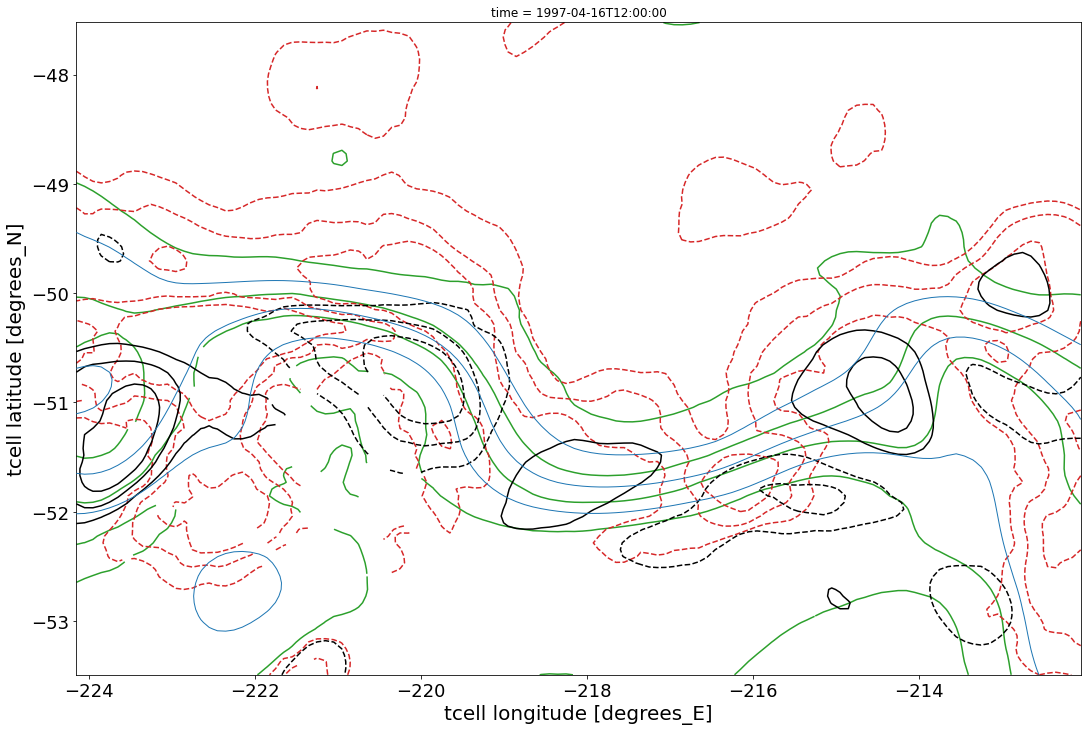

In [35]:
p_contours = [-0.18, -0.12, -0.06, 0.06, 0.12, 0.18]
core_contour = -0.4
sl_contours = [core_contour-0.2, core_contour, core_contour+0.2]

depth=2500
vmin, vmax = -1, -0.1
fig, ax = plt.subplots(figsize=(18,12))

# (sl_lim.sel(time='1997-04-16').isel(time=0) - D.sel(time='1997-04-16').isel(time=0).sel(st_ocean=depth, method='nearest')).plot(
#     ax=ax)
D.sel(time='1997-04-16').isel(time=0).sel(st_ocean=depth, method='nearest').plot.contour(
    ax=ax, colors='tab:green')
cont_Dsl = (sl_lim.sel(time='1997-04-16').isel(time=0) - D.sel(time='1997-04-16').isel(time=0).sel(st_ocean=depth, method='nearest')).plot.contour(
    ax=ax, colors='tab:red', levels=[-2.3, -2.28, -2.26], label=r'$\eta - D$')

cont_p = p_anomalous.sel(st_ocean=depth, method='nearest').sel(time='1997-04-16').isel(time=0).plot.contour(
    ax=ax, levels=p_contours, colors='k', zorder=9, label='p_anom')#cmap=plt.cm.RdGy)
# ax.clabel(cont, p_contours, inline=1, fontsize=fs_small, fmt='%.2f')

cont_sl = sl_lim.sel(time='1997-04-16').isel(time=0).plot.contour(
    ax=ax, levels=sl_contours, linestyles='solid', linewidths=1, colors='tab:blue', zorder=10)

# ax.legend([cont_Dsl, cont_p], bbox_to_anchor=(1.0, .5), prop={'size': 12}, zorder=15)

In [36]:
# geos_vel
# Vg_s = (ug_s**2 + vg_s**2)**(1 / 2)
# Vg_s.plot(cmap=cmo.cm.speed, vmin=0, vmax=1)
# iz = 50
# Vg = ((ug_s - ug.isel(st_ocean=iz))**2 + (vg_s - vg.isel(st_ocean=iz))**2)**(1 / 2)
# Vg.plot(cmap=cmo.cm.speed, vmin=0, vmax=0.3)

# test = vel.sel(time='1997-04-16').isel(time=0)
# test['ugeos'] = ug_s - ug
# test['vgeos'] = vg_s - vg
# test['ures'] = test.u - test.ugeos
# test['vres'] = test.v - test.vgeos
# test['res_vel'] = (test.ures**2 + test.vres**2)**(1/2)

In [37]:
# test = vel.sel(time='1997-04-16').isel(time=0)
# test['ugeos'] = ug_s - ug
# test['vgeos'] = vg_s - vg
# test['ures'] = test.u - test.ugeos
# test['vres'] = test.v - test.vgeos
# test['res_vel'] = (test.ures**2 + test.vres**2)**(1/2)

In [38]:
# geos_vel = xr.merge([vel.sel(time=meander_period), geos_vel])
geos_vel_sel = xr.merge([geos_vel.sel(time='1997-04-16'), vel.sel(time='1997-04-16')])

geos_vel_sel['ures'] = geos_vel_sel.u - geos_vel_sel.ug
geos_vel_sel['vres'] = geos_vel_sel.v - geos_vel_sel.vg

geos_vel_sel = geos_vel_sel.isel(time=0)

In [ ]:
# iz = 0
# Vg = (geos_vel_sel.ug.isel(st_ocean=iz)**2 + geos_vel_sel.vg.isel(st_ocean=iz)**2)**(1 / 2)
# Vg.plot(cmap=cmo.cm.speed, vmin=0, vmax=1)

In [ ]:
# iz = 0
# Vg = ((geos_vel_sel.ug_s - geos_vel_sel.ug.isel(st_ocean=iz))**2 + (geos_vel_sel.vg_s - geos_vel_sel.vg.isel(st_ocean=iz))**2)**(1 / 2)
# Vg.plot(cmap=cmo.cm.speed, vmin=0, vmax=0.001)

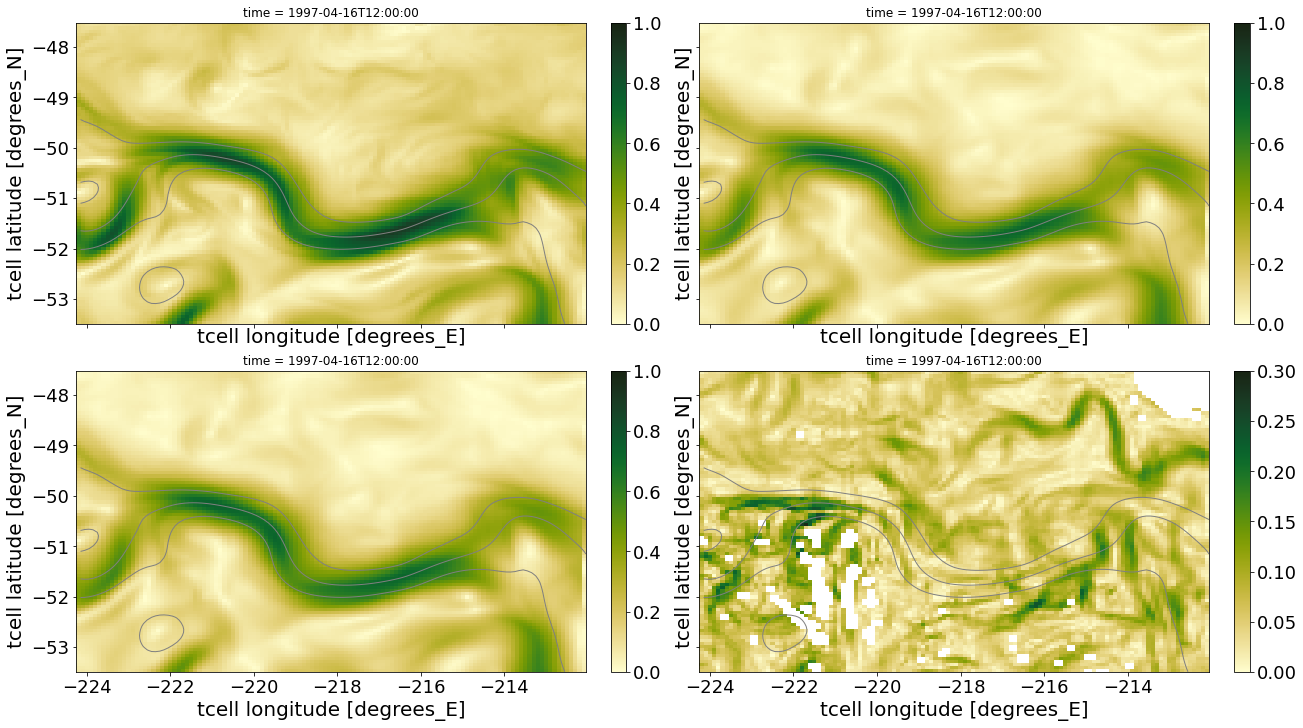

In [ ]:
core_contour = -0.4
sl_contours = [core_contour-0.2, core_contour, core_contour+0.2]
p_contours = [-0.18, -0.12, -0.06, 0.06, 0.12, 0.18]

nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 10), sharex=True, sharey=True, constrained_layout=True)

# Total simulated velocity at surface
V = (geos_vel_sel.u**2 + geos_vel_sel.v**2)**(1 / 2)
V.isel(st_ocean=0).plot(ax=ax[0, 0], cmap=cmo.cm.speed, vmin=0, vmax=1)

# Geostrophic velocity from sea level gradient at surface
Vg_s = (geos_vel_sel.ug_s**2 + geos_vel_sel.vg_s**2)**(1 / 2)
Vg_s.plot(ax=ax[0, 1], cmap=cmo.cm.speed, vmin=0, vmax=1)

# Geostrophic velocity from Dynamic Height gradient at surface
Vg = (geos_vel_sel.ug**2 + geos_vel_sel.vg**2)**(1 / 2)
Vg.sel(st_ocean=0, method='nearest').plot(ax=ax[1, 0], cmap=cmo.cm.speed, vmin=0, vmax=1)

# Geostrophic velocity from Dynamic Height gradient at depth
Vg.sel(st_ocean=2500, method='nearest').plot(ax=ax[1, 1], cmap=cmo.cm.speed, vmin=0, vmax=.3)

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols
    
    cont = geos_vel_sel.sea_level.plot.contour(
        ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray', zorder=10)

In [39]:

V = (geos_vel_sel.u**2 + geos_vel_sel.v**2)**(1 / 2)
Vg = (geos_vel_sel.ug**2 + geos_vel_sel.vg**2)**(1 / 2)
Vres = (geos_vel_sel.ures**2 + geos_vel_sel.vres**2)**(1/2)
# residual = residual.sel(xu_ocean=slice(-224, -212))
# residual = residual.assign_coords({'xu_ocean':((residual.xu_ocean + 180) % 360) - 180})

In [40]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"text.usetex": True, "font.family": 'serif', "font.serif": 'cm', 'font.size': fs_small})

Text(-0.02, 0.5, 'Latitude ($^oS$)')

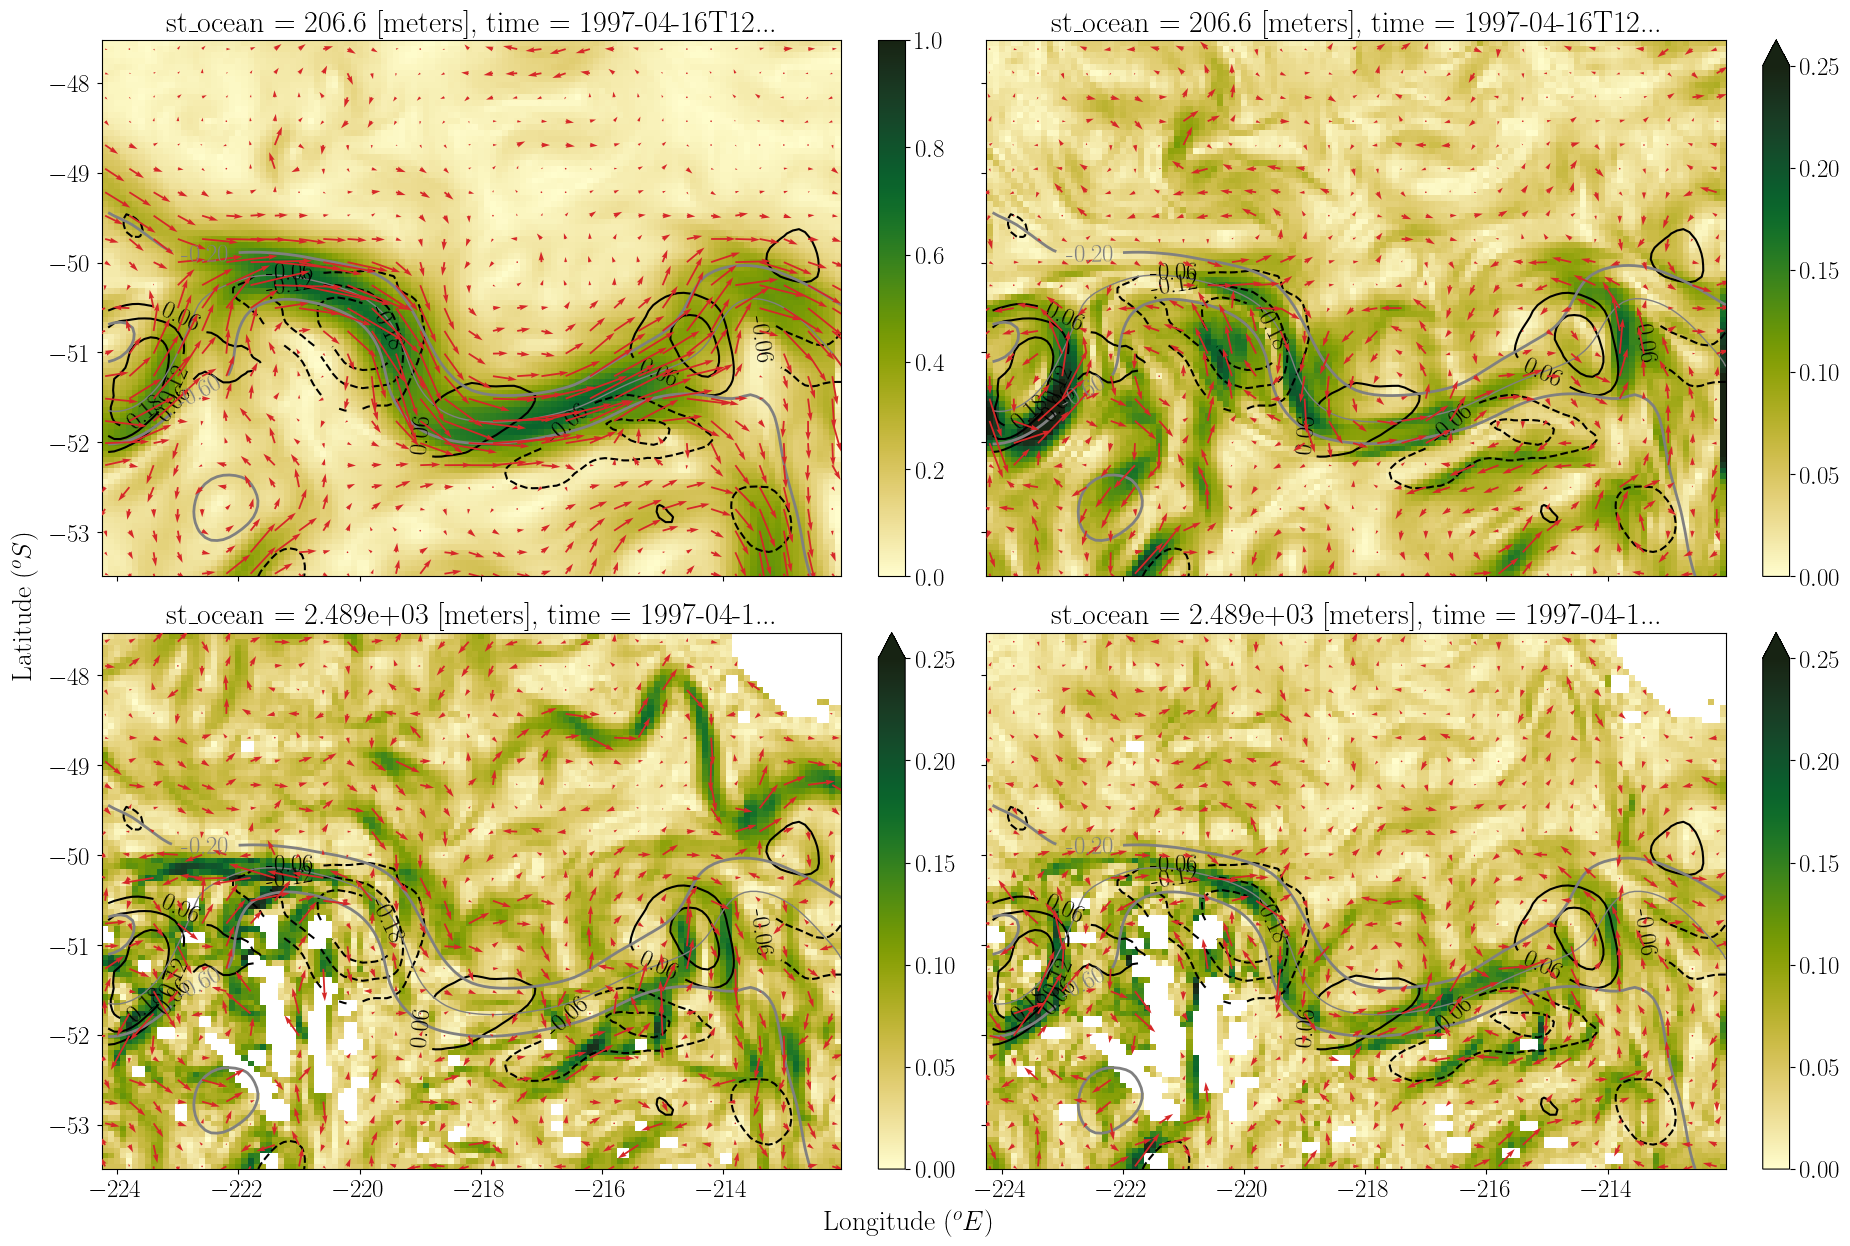

In [41]:

vmin, vmax = 0, 0.25
slc = slice(None, None, 4)
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12), sharex=True, sharey=True, constrained_layout=True)

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols
    
    cont = geos_vel_sel.sea_level.plot.contour(
        ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray', zorder=10)
    for ib, b in enumerate(sl_contours):
        if b in sl_contours[::2]:
            zc = cont.collections[ib]
            plt.setp(zc, linewidth=2)
    ax[r, c].clabel(cont, sl_contours[::2], inline=1, fontsize=fs_small, fmt='%.2f')

    cont = p_anomalous.sel(st_ocean=2500, method='nearest').sel(time='1997-04-16').isel(time=0).plot.contour(
        ax=ax[r, c], levels=p_contours, colors='k', zorder=9)#cmap=plt.cm.RdGy)
    ax[r, c].clabel(cont, p_contours, inline=1, fontsize=fs_small, fmt='%.2f')
    
    ax[r, c].set_xlabel('')
    ax[r, c].set_ylabel('')


pcol = Vg.sel(st_ocean=200, method='nearest').plot(
    ax=ax[0, 0], cmap=cmo.cm.speed, vmin=vmin, vmax=1)
geos_vel_sel.sel(st_ocean=200, method='nearest').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax[0, 0], x='xu_ocean', y='yu_ocean', u='ug', v='vg',
    units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], pivot='tail', add_guide=False, color='tab:red', zorder=11)

Vg.sel(st_ocean=2500, method='nearest').plot(
    ax=ax[1, 0], cmap=cmo.cm.speed, vmin=vmin, vmax=vmax)
geos_vel_sel.sel(st_ocean=2500, method='nearest').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax[1, 0], x='xu_ocean', y='yu_ocean', u='ug', v='vg',
    units='inches', scale=0.5, width=1e-3*fig.get_size_inches()[0], pivot='tail', add_guide=False, color='tab:red', zorder=11)

pcol2 = Vres.sel(st_ocean=200, method='nearest').plot(
    ax=ax[0, 1], cmap=cmo.cm.speed, vmin=vmin, vmax=vmax)
geos_vel_sel.sel(st_ocean=200, method='nearest').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax[0, 1], x='xu_ocean', y='yu_ocean', u='ures', v='vres',
    units='inches', scale=0.5, width=1e-3*fig.get_size_inches()[0], pivot='tail', add_guide=False, color='tab:red', zorder=11)

Vres.sel(st_ocean=2500, method='nearest').plot(
    ax=ax[1, 1], cmap=cmo.cm.speed, vmin=vmin, vmax=vmax)
geos_vel_sel.sel(st_ocean=2500, method='nearest').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax[1, 1], x='xu_ocean', y='yu_ocean', u='ures', v='vres',
    units='inches', scale=0.5, width=1e-3*fig.get_size_inches()[0], pivot='tail', add_guide=False, color='tab:red', zorder=11)

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols
    ax[r, c].set_xlabel('')
    ax[r, c].set_ylabel('')
# cbar = fig.colorbar(pcol2, ax=ax[:,1:], aspect=50, extend='both', orientation='horizontal')
# cbar.ax.set_ylabel('$ms^{-1}$', fontsize=fs_large)

# cbar = fig.colorbar(pcol2, ax=ax[:,1:], aspect=50, extend='both', orientation='horizontal')
# cbar.ax.set_ylabel('$V_g, \mathrm{ms}^{-1}$', fontsize=fs_large)

fig.text(0.48, -0.02, r'Longitude ($^oE$)', ha='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Latitude ($^oS$)', va='center', rotation='vertical', fontsize=fs_large)

In [42]:
zeta_res = relative_vorticity(geos_vel_sel.sel(st_ocean=200, method='nearest'), grid, vel_names=('ures', 'vres'), delta_names=('dxt', 'dyt'))

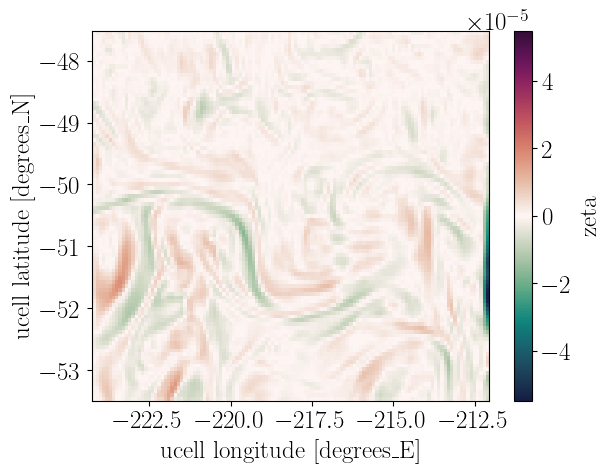

In [43]:
zeta_res.plot(cmap=cmo.cm.curl)

In [44]:
# ug, vg = xr.apply_ufunc(geostrophic_velocity_from_TS, ds.so, ds.thetao,
#                     dask='parallelized',
#                     output_dtypes=[ds.so.dtype])

# deltaD_grd = xr.merge([coordinates, deltaD])
# ug, vg = geostrophic_velocity(deltaD_grd, grid, delta_names=('dxt', 'dyt'))
# vel_geos = xr.merge([deltaD_grd, ug, vg])

In [45]:
# dDdx_t = grid.interp(grid.diff(deltaD_grd.deltaD, 'X', boundary='extend'), 'Y', boundary='extend') / deltaD_grd.dxt
# dDdy_t = grid.interp(grid.diff(deltaD_grd.deltaD, 'Y', boundary='extend'), 'X', boundary='extend') / deltaD_grd.dyt

# vg_u = grid.interp(grid.interp(dDdx_t, 'Y', boundary='extend'), 'X', boundary='extend')
# ug_u = - grid.interp(grid.interp(dDdy_t, 'Y', boundary='extend'), 'X', boundary='extend')

# test = xr.merge([ug_u.compute(), vg_u])

# (ug_u**2 + vg_u**2)**(1/2)
# (test.ug**2 + test.ug**2)**(1/2)
# (vel_geos.ug**2 + vel_geos.vg**2)**(1 / 2)

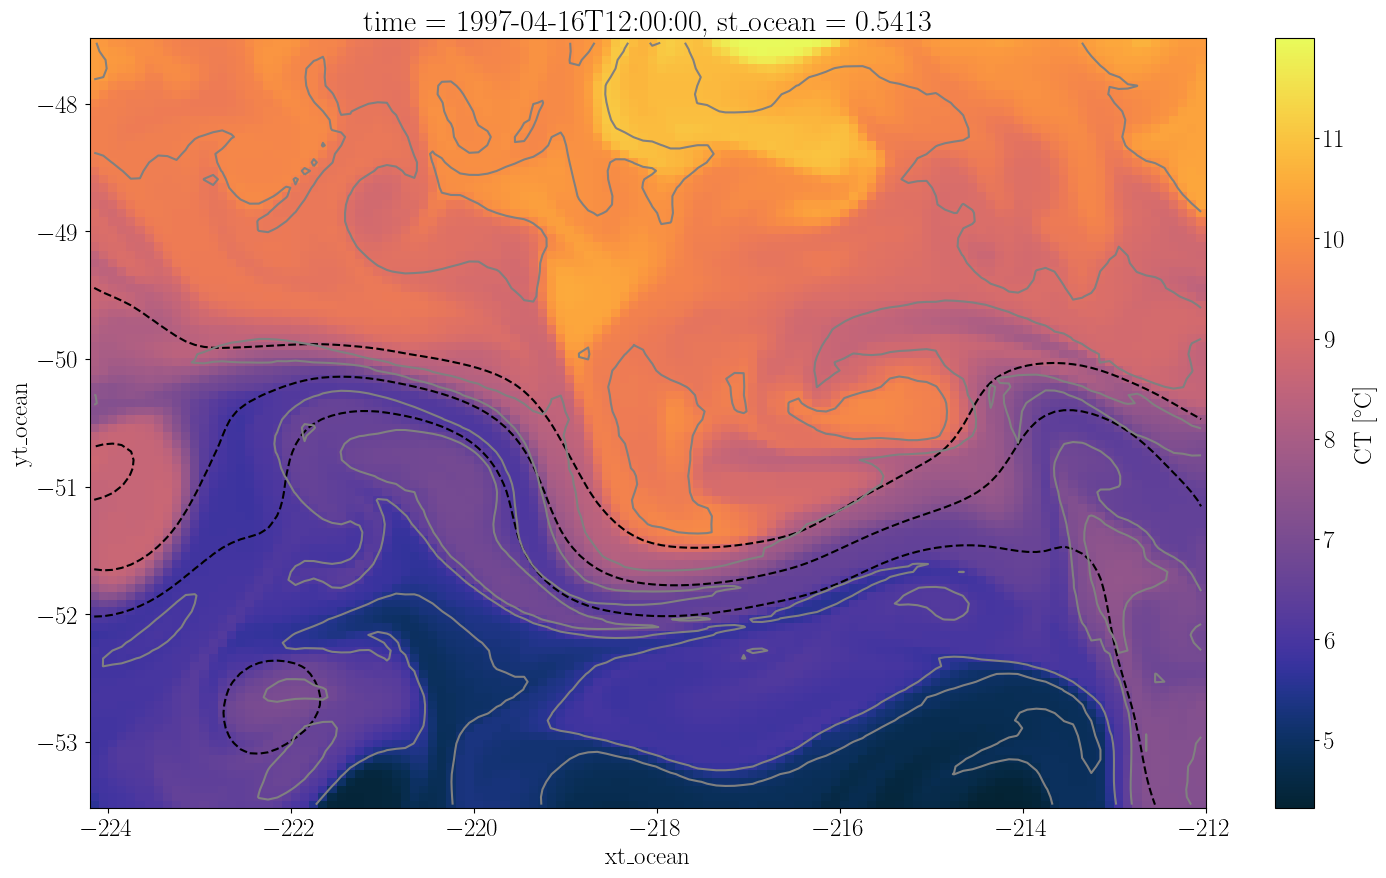

In [46]:
fig, ax = plt.subplots(figsize=(18,10))
CT.sel(time='1997-04-16').isel(time=0, st_ocean=0).plot(ax=ax, cmap=cmo.cm.thermal)
sl_lim.sel(time='1997-04-16').isel(time=0).plot.contour(ax=ax, levels=[-0.6, -0.4, -0.2], colors='k')
cont = deltaD.sel(time='1997-04-16').isel(time=0, st_ocean=0).plot.contour(ax=ax, colors='gray', add_labels=True)
# plt.clabel(cont, sl_contours[::2], inline=1, fontsize=fs_small, fmt='%.2f')

$$ p_\mathrm{surface} = \rho_0 g \eta$$

In [47]:
# msl = sl_lim.mean('time')
# msl = ccd.compute_by_block(msl)
# sla = sl_lim.sel(time=meander_period) - msl
# p_plus_sl = p.sel(time=monthly_mean) + (rho_0 * g * sla.sel(time=monthly_mean)).compute()
# p_plus_sl_mean = p_plus_sl.mean('time')

## Geostrophic velocities

In [48]:
# # https://cosima-recipes.readthedocs.io/en/latest/documented_examples/Barotropic_Streamfunction.html#gallery-documented-examples-barotropic-streamfunction-ipynb

# def geostophic_velocity(ds, grid, rho_0=1025, p='p'):
    
#     # # density anomaly
#     # rho_prime = rho - rho_0
    
#     # buoyancy
#     # b = -g * rho_prime / rho_0
    
#     # Coriolis parameter
#     fcor,_ = xr.broadcast(f(ds.yu_ocean), ds.xu_ocean)
    
#     # pressure gradient
#     # dpdx = grid.diff(ds[p] * ds.dyt, 'X', boundary='fill') / ds.area_u
#     # dpdy = grid.diff(ds[p] * ds.dxt, 'Y', boundary='fill') / ds.area_u
#     dpdx = grid.interp(grid.diff(ds[p], 'X', boundary='extend'), 'Y', boundary='extend') / ds.dxu
#     dpdy = grid.interp(grid.diff(ds[p], 'Y', boundary='extend'), 'X', boundary='extend') / ds.dyu
    
#     # geostrophic components
#     ug = - (1 / (rho_0*fcor)) * dpdy
#     vg = (1 / (rho_0*fcor)) * dpdx
    
#     ug.name = 'ug'
#     vg.name = 'vg'
    
#     ds = xr.merge([ds, ug, vg])
    
#     return ds

# # vel_geos = geostophic_velocity(pressure, grid, rho_0=rho_0, p='pbot_t')
# # vel_geos = geostophic_velocity(p_grd.sel(time=monthly_mean), grid, rho_0=rho_0, p='pressure')

In [49]:
# pbot_mm = p.sel(time=monthly_mean).mean('time').isel(st_ocean=kmt_lim)

# fig,ax=plt.subplots(ncols=3, figsize=(18, 6))
# pbot_tlim.plot(ax=ax[0])
# pbot_mm.plot(ax=ax[1])
# (pbot_tlim - pbot_mm).plot(ax=ax[2])

In [50]:
# Vgeos = (vel_geos.ug**2 + vel_geos.vg**2)**(1/2)
# Vgeos.isel(st_ocean=50).mean('time').plot(cmap=cmo.cm.speed)

In [51]:
# velocity dataset
zeta = relative_vorticity(vel, grid, delta_names=('dxt', 'dyt'))
# ds = ds.assign_coords(xt_ocean=((ds.xt_ocean + 180) % 360) - 180)
qgvb = xr.merge([vel, zeta])

# wind and bottom stress dataset
wind_stress = xr.merge([coordinates, tau_xlim, tau_ylim])
bottom_stress = xr.merge([coordinates, bmf_ulim, bmf_vlim])
vel_monthly = xr.merge([coordinates, u_monthly, v_monthly, wt_monthly])

# # pressure
# p_grd = xr.merge([coordinates, pressure])


## Ekman velocities
- http://www.geo.cornell.edu/ocean/p_ocean/ppt_notes/16_EkmanTransport.pdf
- https://geo.libretexts.org/Bookshelves/Oceanography/Book%3A_Geophysical_Flows_(Omta)/07%3A_Basis_of_Wind-Driven_Circulation_-_Ekman_spiral_and_transports
- https://www.frontiersin.org/articles/10.3389/fmars.2021.672477/full


$$u_e = \frac{1}{\rho\sqrt{2A_z\left|f\right|}}\left(\tau_x-\tau_y\right)$$
$$v_e = \frac{1}{\rho\sqrt{2A_z\left|f\right|}}\left(\tau_x+\tau_y\right)$$

$A_z = 8 \times 10^{-3}~\mathrm{m}^2\mathrm{s}^{-1}$
$\rho = 1025~\mathrm{kg}\mathrm{m}^{-3}$

In [52]:
A_z=200e-2

In [53]:
# eddy viscosity
# A_v = 0.05 #m^2s^-1
def ekman_velocity(ds, grid, rho_0=1025, A_z=8e-3, hemisphere='N'):
    
    # Coriolis parameter
    fcor,_ = xr.broadcast(f(ds.yu_ocean), ds.xu_ocean)
    
    # u_e = (1 / (rho_0 * (2 * A_z * np.abs(fcor))**(1/2))) * (ds.tau_x - ds.tau_y)
    # v_e = (1 / (rho_0 * (2 * A_z * np.abs(fcor))**(1/2))) * (ds.tau_x + ds.tau_y)
    # ds['tau'] = (ds.tau_x**2 + ds.tau_y**2)**(1/2)
    V_x0 = ds.tau_x / (rho_0**2 * np.abs(fcor) * A_z)**(1/2)
    V_y0 = ds.tau_y / (rho_0**2 * np.abs(fcor) * A_z)**(1/2)
    a = (np.abs(fcor) / (2 * A_z))**(1/2)

    phase = np.pi / 4

    ds['ue'] = V_x0 * np.exp(a * -ds.st_ocean) * np.cos(-phase + (a * -ds.st_ocean)) + V_y0 * np.exp(a * -ds.st_ocean) * np.cos(phase + (a * -ds.st_ocean)) # 
    ds['ve'] = V_x0 * np.exp(a * -ds.st_ocean) * np.sin(-phase + (a * -ds.st_ocean)) + V_y0 * np.exp(a * -ds.st_ocean) * np.sin(phase + (a * -ds.st_ocean)) # 
    
    if hemisphere == 'S':
        ds['ue'] = V_x0 * np.exp(a * -ds.st_ocean) * np.cos(-phase + (a * -ds.st_ocean)) - V_y0 * np.exp(a * -ds.st_ocean) * np.cos(phase + (a * -ds.st_ocean))
        ds['ve'] = - V_x0 * np.exp(a * -ds.st_ocean) * np.sin(-phase + (a * -ds.st_ocean)) + V_y0 * np.exp(a * -ds.st_ocean) * np.sin(phase + (a * -ds.st_ocean))
    
    return ds

Ek = ekman_velocity(wind_stress, grid, hemisphere='S', rho_0=rho_0, A_z=A_z)

## Curvature velocities

TODO: Determine stream function (Dynamic Height/ Sea Level) to apply gradient wind balance throughout the water column

In [54]:
UTM54 = 'EPSG:32754'

gw = gradient_wind_from_ssh(geos_vel.sel(time='1997-04-16').sea_level, transform=UTM54, 
                                   dimensions=('time', 'yt_ocean', 'xt_ocean'))

uc_u = grid.interp(grid.interp(gw.uag, 'X'), 'Y')
vc_u = grid.interp(grid.interp(gw.vag, 'X'), 'Y')
uc_u.name, vc_u.name = 'uc', 'vc'


In [55]:
flow = xr.merge([geos_vel_sel, Ek.isel(time=0), uc_u.isel(time=0), vc_u.isel(time=0)], compat='override')

In [56]:
flow

<xarray.Dataset>
Dimensions:    (xt_ocean: 122, yt_ocean: 95, st_ocean: 75, xu_ocean: 122,
                yu_ocean: 94, sw_ocean: 75)
Coordinates:
  * xt_ocean   (xt_ocean) float64 -224.1 -224.0 -223.9 ... -212.2 -212.1 -212.0
  * yt_ocean   (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time       datetime64[ns] 1997-04-16T12:00:00
  * xu_ocean   (xu_ocean) float64 -224.2 -224.1 -224.0 ... -212.3 -212.2 -212.1
  * yu_ocean   (yu_ocean) float64 -53.46 -53.4 -53.34 ... -47.69 -47.62 -47.56
  * sw_ocean   (sw_ocean) float64 1.083 2.279 3.601 ... 5.61e+03 5.809e+03
Data variables: (12/29)
    dxt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    dst        (st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(19, 66, 122), meta=np.ndarray>
    dxu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    dyu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    area_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    ...         ...
    tau_x      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    tau_y      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    ue         (yu_ocean, xu_ocean, st_ocean) float64 dask.array<chunksize=(94, 122, 75), meta=np.ndarray>
    ve         (yu_ocean, xu_ocean, st_ocean) float64 dask.array<chunksize=(94, 122, 75), meta=np.ndarray>
    uc         (yu_ocean, xu_ocean) float64 -0.0002515 -0.0003146 ... 0.0002499
    vc         (yu_ocean, xu_ocean) float64 0.0002476 0.0003803 ... 6.596e-05
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-06-09
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Source code: https://github.com/COSIMA/access-om2 License:...

In [57]:
flow = flow.drop_vars(['ures', 'vres'])

# residual flow (total flow - geostrophic and ageostrophic (Ekman and curvature) flow)
flow['ures'] = flow.u - flow.ug - flow.ue
flow['vres'] = flow.v - flow.vg - flow.ve

# ageostrophic flow (Ekman + curvature)
flow['uag'] = flow.uc + flow.ue
flow['vag'] = flow.vc + flow.ve

In [58]:
zeta_ag = relative_vorticity(flow.isel(st_ocean=0), grid, vel_names=('uag', 'vag'), delta_names=('dxt', 'dyt'))
div_ag = horizontal_divergence(flow.isel(st_ocean=0), grid, vel_names=('uag', 'vag'), delta_names=('dxt', 'dyt'))
zeta_res = relative_vorticity(flow.isel(st_ocean=30), grid, vel_names=('ures', 'vres'), delta_names=('dxt', 'dyt'))

In [59]:
flow.isel(st_ocean=0).plot.quiver(
    ax=ax, x='xu_ocean', y='yu_ocean', u='uag', v='vag',
    units='inches', scale=0.5, width=1e-3*fig.get_size_inches()[0], pivot='tail', add_guide=False, color='tab:gray', zorder=11)

<a list of 3 text.Text objects>

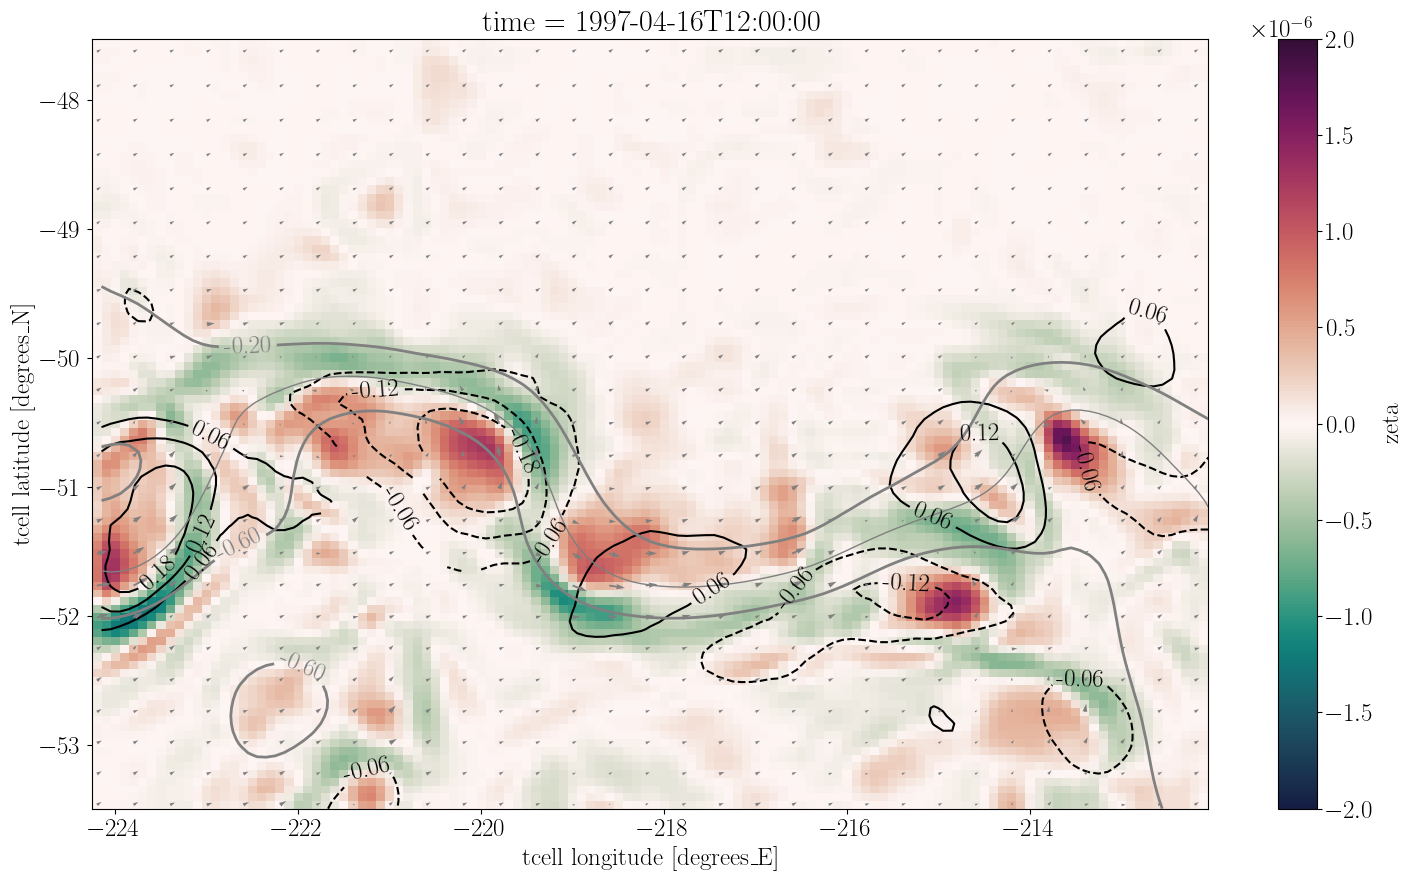

In [61]:
fig, ax = plt.subplots(figsize=(18,10))
zeta_ag.plot(ax=ax, cmap=cmo.cm.curl, vmin=-2e-6, vmax=2e-6)
flow.isel(st_ocean=0).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax, x='xu_ocean', y='yu_ocean', u='uag', v='vag',
    units='inches', scale=0.3, width=1e-3*fig.get_size_inches()[0], pivot='tail', add_guide=False, color='tab:gray', zorder=11)

cont = p_anomalous.sel(st_ocean=2500, method='nearest').sel(time='1997-04-16').isel(time=0).plot.contour(
    ax=ax, levels=p_contours, colors='k', zorder=9)#cmap=plt.cm.RdGy)
ax.clabel(cont, p_contours, inline=1, fontsize=fs_small, fmt='%.2f')
cont = geos_vel_sel.sea_level.plot.contour(
    ax=ax, levels=sl_contours, linestyles='solid', linewidths=1, colors='gray', zorder=10)
for ib, b in enumerate(sl_contours):
    if b in sl_contours[::2]:
        zc = cont.collections[ib]
        plt.setp(zc, linewidth=2)
ax.clabel(cont, sl_contours[::2], inline=1, fontsize=fs_small, fmt='%.2f')

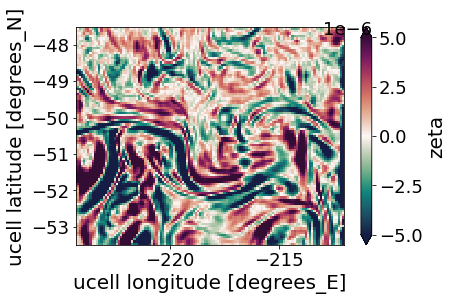

In [94]:
zeta_res.plot(cmap=cmo.cm.curl, vmin=-5e-6, vmax=5e-6)

2022-10-01 19:16:45,597 - distributed.nanny - WARNING - Restarting worker


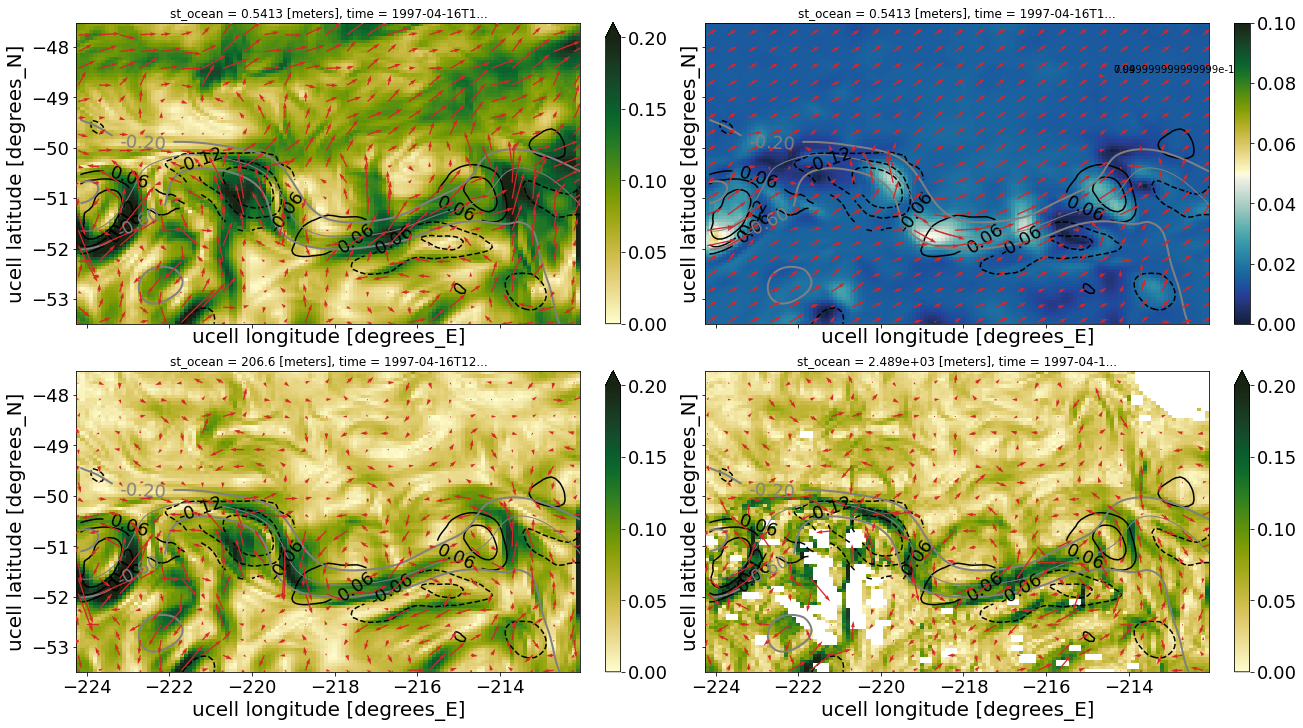

In [81]:
core_contour = -0.4
sl_contours = [core_contour-0.2, core_contour, core_contour+0.2]
p_contours = [-0.18, -0.12, -0.06, 0.06, 0.12, 0.18]

nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 10), sharex=True, sharey=True, constrained_layout=True)

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols
    
    # sea level contours
    cont = geos_vel_sel.sea_level.plot.contour(
        ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray', zorder=10)
    for ib, b in enumerate(sl_contours):
        if b in sl_contours[::2]:
            zc = cont.collections[ib]
            plt.setp(zc, linewidth=2)
    ax[r, c].clabel(cont, sl_contours[::2], inline=1, fontsize=fs_small, fmt='%.2f')


    # deep pressure anomalies
    cont = p_anomalous.sel(st_ocean=2500, method='nearest').sel(time='1997-04-16').isel(time=0).plot.contour(
        ax=ax[r, c], levels=p_contours, colors='k', zorder=9)#cmap=plt.cm.RdGy)
    ax[r, c].clabel(cont, p_contours, inline=1, fontsize=fs_small, fmt='%.2f')

# Residual velocities at surface
Vres = (flow.ures**2 + flow.vres**2)**(1 / 2)
Vres.isel(st_ocean=0).plot(ax=ax[0, 0], cmap=cmo.cm.speed, vmin=0, vmax=0.2)
flow.isel(st_ocean=0).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax[0, 0], x='xu_ocean', y='yu_ocean', u='ures', v='vres',
    units='inches', scale=0.4, width=1e-3*fig.get_size_inches()[0], pivot='tail', color='tab:red', zorder=11)

# Curvature and Ekman velocities at surface
Vc = (flow.uag**2 + flow.vag**2)**(1 / 2)
Vc.isel(st_ocean=0).plot(ax=ax[0, 1], cmap=cmo.cm.delta, vmin=0, vmax=0.1)
flow.isel(st_ocean=0).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax[0, 1], x='xu_ocean', y='yu_ocean', u='uag', v='vag',
    units='inches', scale=0.1, width=1e-3*fig.get_size_inches()[0], pivot='tail', color='tab:red', zorder=11, add_guide=False)

# Residual velocities below mixed layer
Vres.sel(st_ocean=200, method='nearest').plot(ax=ax[1, 0], cmap=cmo.cm.speed, vmin=0, vmax=0.2)
flow.sel(st_ocean=200, method='nearest').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax[1, 0], x='xu_ocean', y='yu_ocean', u='ures', v='vres',
    units='inches', scale=0.4, width=1e-3*fig.get_size_inches()[0], pivot='tail', color='tab:red', zorder=11)

# Residual velocities at depth (2500m)
Vres.sel(st_ocean=2500, method='nearest').plot(ax=ax[1, 1], cmap=cmo.cm.speed, vmin=0, vmax=0.2)
flow.sel(st_ocean=2500, method='nearest').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(
    ax=ax[1, 1], x='xu_ocean', y='yu_ocean', u='ures', v='vres',
    units='inches', scale=0.4, width=1e-3*fig.get_size_inches()[0], pivot='tail', color='tab:red', zorder=11)


## Gradient wind velocities

In [69]:

# Calculate flow speed at the surface
sea_level = sl_lim.sel(time=monthly_mean)

# Calculate gradient wind and geostrophic velocities from sea level
UTM54 = 'EPSG:32754'
gw_smooth = gradient_wind_from_ssh(sea_level, transform=UTM54, 
                                   dimensions=('time', 'yt_ocean', 'xt_ocean'), 
                                   smooth={'boxcar': 3})
gw = gradient_wind_from_ssh(sea_level, transform=UTM54, 
                                   dimensions=('time', 'yt_ocean', 'xt_ocean'))

In [70]:
# total simulated velocities
ut = grid.interp(grid.interp(u_monthly, 'X'), 'Y')
vt = grid.interp(grid.interp(v_monthly, 'X'), 'Y')
ut.name, vt.name = 'utot', 'vtot'

# Ekman velocities
ut_e = grid.interp(grid.interp(Ek.ue, 'X'), 'Y')
vt_e = grid.interp(grid.interp(Ek.ue, 'X'), 'Y')
ut_e.name, vt_e.name = 'ue', 've'

# merge with gradient velocities
gw_mm = xr.merge([gw.mean('time'), ut.isel(time=0), vt.isel(time=0), ut_e.isel(time=0), vt_e.isel(time=0)])
gw_mm = gw_mm.rename({'uag': 'uc', 'vag': 'vc'})



In [71]:
gw_mm['ures'] = gw_mm['utot'] - (gw_mm['ug'] + gw_mm['ue'] + gw_mm['uc'])
gw_mm['vres'] = gw_mm['vtot'] - (gw_mm['vg'] + gw_mm['ve'] + gw_mm['vc'])

In [60]:
cmap = cmo.cm.tarn
vmin, vmax = -1e-6, 1e-6
slcx, slcy = slice(None, None, 10), slice(None, None, 10)

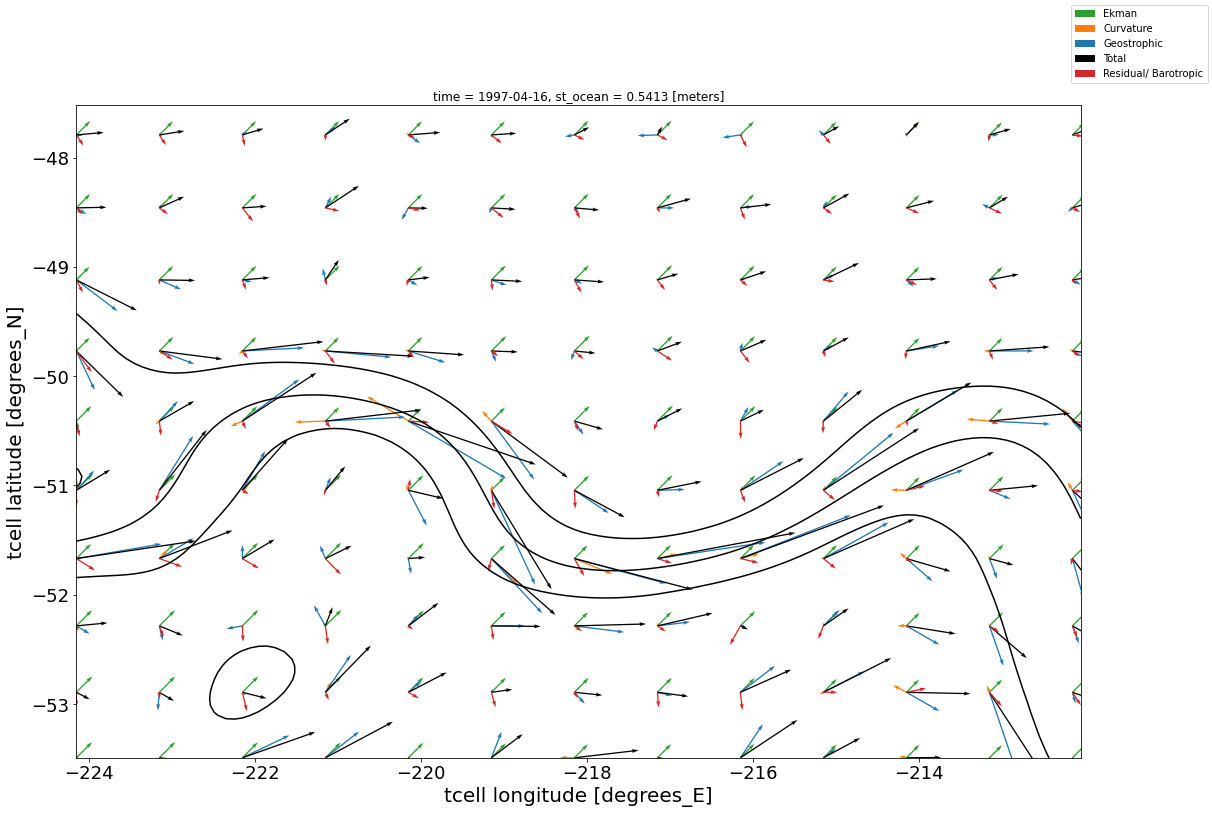

In [61]:
# depths = [0, 10, 20, 50]
core_contour = -0.4
sl_contours = [core_contour-0.2, core_contour, core_contour+0.2]

fig, ax = plt.subplots(figsize=(18,12))
# tau = (wind_stress.tau_x**2 + wind_stress.tau_y**2)**(1/2)
# tau.plot(ax=ax, cmap=cmo.cm.speed)

sea_level.mean('time').plot.contour(colors='k', levels=sl_contours, linestyles='solid')

# wind_stress.isel(time=0).sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(ax=ax, x='xu_ocean', y='yu_ocean', u='tau_x', v='tau_y',
#         units='inches', scale=0.5, width=1e-3*fig.get_size_inches()[0], add_guide=False, color='skyblue', pivot='tail', label='wind_stress')

# for iz, z in enumerate(depths): #20, 50, 100, 200]:
    
#     ncolor = int(iz * (cmap.N / (len(depths)-1)))

gw_mm.sel(st_ocean=0, method='nearest').sel(xt_ocean=slcx, yt_ocean=slcy).plot.quiver(
    ax=ax, x='xt_ocean', y='yt_ocean', u='ue', v='ve',
    units='inches', scale=0.4, width=1e-3*fig.get_size_inches()[0], add_guide=False, pivot='tail', color='tab:green', label='Ekman')

gw_mm.sel(xt_ocean=slcx, yt_ocean=slcy).plot.quiver(
    ax=ax, x='xt_ocean', y='yt_ocean', u='uc', v='vc',
    units='inches', scale=0.04, width=1e-3*fig.get_size_inches()[0], add_guide=False, pivot='tail', color='tab:orange', label='Curvature')

gw_mm.sel(xt_ocean=slcx, yt_ocean=slcy).plot.quiver(
    ax=ax, x='xt_ocean', y='yt_ocean', u='ug', v='vg',
    units='inches', scale=0.4, width=1e-3*fig.get_size_inches()[0], add_guide=False, pivot='tail', color='tab:blue', label='Geostrophic')

gw_mm.sel(st_ocean=0, method='nearest').sel(xt_ocean=slcx, yt_ocean=slcy).plot.quiver(
    ax=ax, x='xt_ocean', y='yt_ocean', u='utot', v='vtot',
    units='inches', scale=0.4, width=1e-3*fig.get_size_inches()[0], add_guide=False, pivot='tail', color='k', label='Total')

gw_mm.sel(st_ocean=0, method='nearest').sel(xt_ocean=slcx, yt_ocean=slcy).plot.quiver(
    ax=ax, x='xt_ocean', y='yt_ocean', u='ures', v='vres',
    units='inches', scale=0.4, width=1e-3*fig.get_size_inches()[0], add_guide=False, pivot='tail', color='tab:red', label='Residual/ Barotropic')

# .sel(st_ocean=z, method='nearest')

fig.legend()

In [62]:
# vector = ds.isel(time=0).sel(xu_ocean=-218, yu_ocean=-48, method='nearest')

# fig, ax = plt.subplots(figsize=(18,18))
# vector.plot.quiver(
#     ax=ax, x='xu_ocean', y='yu_ocean', u='tau_x', v='tau_y',
#         units='inches', scale=0.1, width=1e-3*fig.get_size_inches()[0], add_guide=False, color='r', pivot='tail')
# vector.plot.quiver(
#         ax=ax, x='xu_ocean', y='yu_ocean', u='u_e', v='v_e',
#         units='inches', scale=0.05, width=1e-3*fig.get_size_inches()[0], add_guide=False, pivot='tail')
# ax.axis('equal')

## Horizontal divergence

In [63]:
vel_month = xr.merge([coordinates, sl_lim.sel(time=monthly_mean),
               u_lim.sel(time=monthly_mean), v_lim.sel(time=monthly_mean)])

In [64]:
divu = horizontal_divergence(vel_month, grid, delta_names=('dxt', 'dyt'))
divu_mm = horizontal_divergence(vel_monthly, grid, delta_names=('dxt', 'dyt'))
divu_mm.name = 'div_utot'
ekman_divu = horizontal_divergence(Ek, grid, vel_names=('ue', 've'), delta_names=('dxt', 'dyt'))
ekman_divu.name = 'div_ue'
gw_divu = horizontal_divergence(xr.merge([coordinates.drop_vars('time'), gw_mm]), grid, vel_names=('uc', 'vc'), delta_names=('dxu', 'dyu'))
gw_divu = grid.interp(grid.interp(gw_divu, 'X'), 'Y')
gw_divu.name = 'div_uc'

divu_res = horizontal_divergence(xr.merge([coordinates.drop_vars('time'), gw_mm]), grid, vel_names=('ures', 'vres'), delta_names=('dxu', 'dyu'))
divu_res = grid.interp(grid.interp(divu_res, 'X'), 'Y')

In [65]:
# gw_divu = horizontal_divergence(xr.merge([coordinates.drop_vars('time'), gw_mm]), grid, vel_names=('uc', 'vc'), delta_names=('dxu', 'dyu'))
# gw_divu.name = 'div_uc'

In [66]:
# # test hor divergence monthly mean vs daily
# vmin, vmax = -1e-7, 1e-7
# fig,ax=plt.subplots(ncols=3, figsize=(18, 6))
# divu.sel(time=slice('1997-04-01', '1997-04-30')).mean('time').isel(st_ocean=0).plot(ax=ax[0], vmin=vmin, vmax=vmax)
# divu_mm.sel(time='1997-04-16').isel(st_ocean=0).plot(ax=ax[1], vmin=vmin, vmax=vmax)
# (divu.sel(time=slice('1997-04-01', '1997-04-30')).mean('time').isel(st_ocean=0) - divu_mm.sel(time='1997-04-16').isel(st_ocean=0)).plot(ax=ax[2], vmin=vmin, vmax=vmax)

In [67]:
# # aligning monthly mean time with daily 
# rsmp = sl_lim.resample(time='1M')
# time_labels = []
# for val in rsmp.groups.values():
    
#     try:
#         idx_mid = int(val.start + ((val.stop - val.start) / 2))
#     except TypeError:
#         stop = len(sl_lim.time)
#         idx_mid = int(val.start + ((stop - val.start) / 2))
#     # print(idx_mid)
#     time_labels.append(sl_lim.time[idx_mid].values)
    
# rsmp = sl_lim.resample(time='1M').mean('time')
# # rsmp.assign_coords(time2=np.array(time_labels))
# sl_monthy = rsmp.assign_coords({'time': time_labels})

In [68]:
# # test sea level monthly mean vs daily
# fig,ax=plt.subplots(ncols=3, figsize=(18, 6))
# sl_lim.sel(time=slice('1997-04-01', '1997-04-30')).mean('time').plot(ax=ax[0])
# sl_monthy.sel(time='1997-04-16').plot(ax=ax[1])
# (sl_lim.sel(time=slice('1997-04-01', '1997-04-30')).mean('time') - sl_monthy.sel(time='1997-04-16')).plot(ax=ax[2])

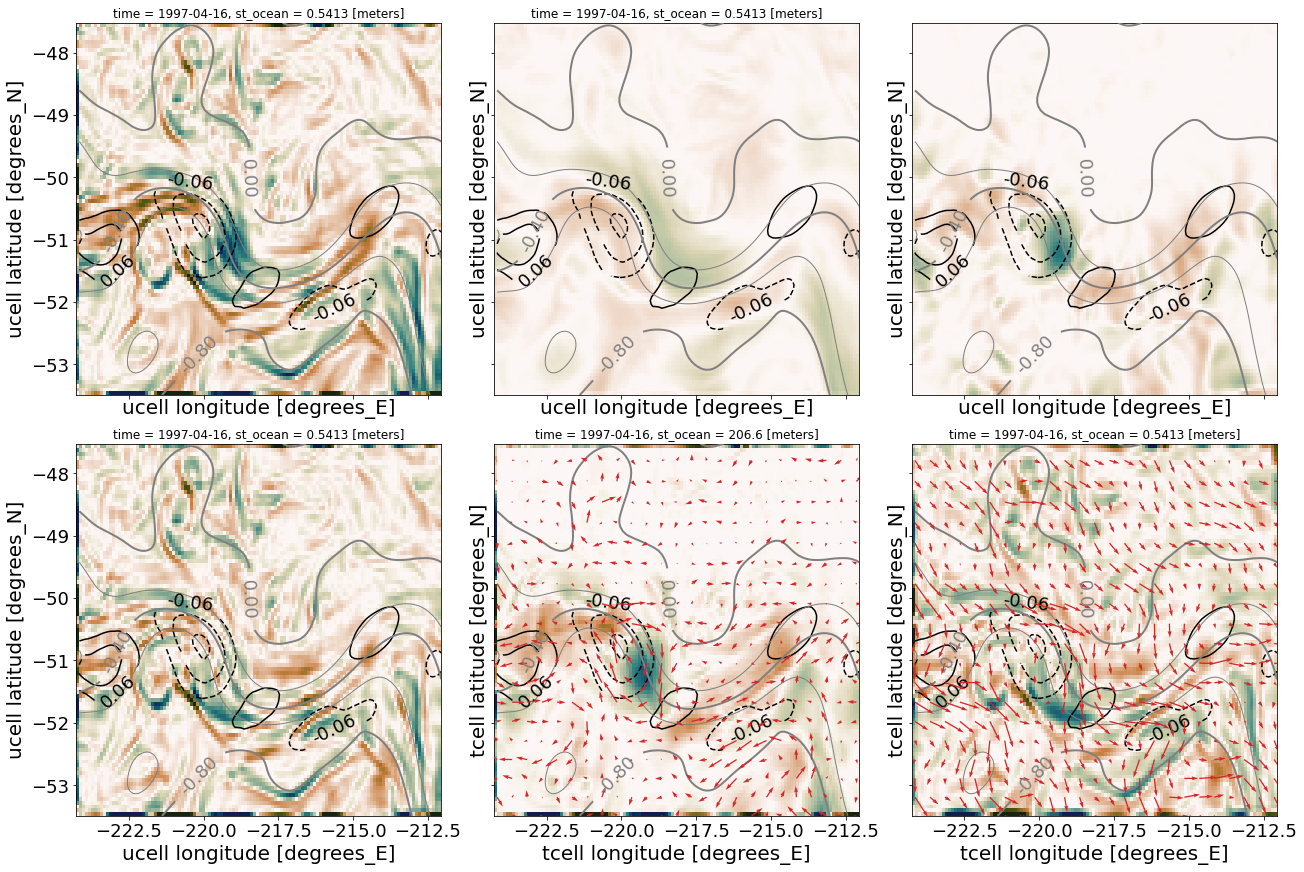

In [69]:
slc = slice(None, None, 5)
cmap = cmo.cm.tarn
vmin, vmax = -1e-6, 1e-6
p_contours = [-0.18, -0.12, -0.06, 0.06, 0.12, 0.18]
core_contour = -0.4
sl_contours = np.linspace(-0.4, 0.4, 5) + core_contour #[core_contour-0.2, core_contour, core_contour+0.2]

nrows, ncols = 2, 3
fig,ax=plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 12), sharex=True, sharey=True, constrained_layout=True)

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols

    # if (r, c) != (2, 1):
    cont = sea_level.mean('time').plot.contour(
        ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray', zorder=10)
    for ib, b in enumerate(sl_contours):
        if b in sl_contours[::2]:
            zc = cont.collections[ib]
            plt.setp(zc, linewidth=2)
    ax[r, c].clabel(cont, sl_contours[::2], inline=1, fontsize=fs_small, fmt='%.2f')

    cont = p_anomalous.sel(st_ocean=p_int, method='nearest').sel(time=monthly_mean).mean('time').plot.contour(
        ax=ax[r, c], levels=p_contours, colors='k', zorder=9)#cmap=plt.cm.RdGy)
    ax[r, c].clabel(cont, p_contours, inline=1, fontsize=fs_small, fmt='%.2f')
    
divu_mm.isel(time=0, st_ocean=0).plot(ax=ax[0, 0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
ekman_divu.isel(time=0, st_ocean=0).plot(ax=ax[0, 1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

gw_divu.plot(ax=ax[0, 2], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
((divu_mm - ekman_divu).isel(time=0, st_ocean=0) - gw_divu).plot(ax=ax[1, 0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

divu_mm.isel(time=0, st_ocean=30).plot(ax=ax[1, 1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
gw_mm.sel(st_ocean=200, method='nearest').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[1, 1], x='xt_ocean', y='yt_ocean', u='ures', v='vres',
    units='inches', scale=0.4, width=1e-3*fig.get_size_inches()[0], add_guide=False, pivot='tail', color='tab:red', zorder=11)

divu_res.isel(st_ocean=0).plot(ax=ax[1, 2], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
gw_mm.sel(st_ocean=0, method='nearest').sel(xt_ocean=slc, yt_ocean=slc).plot.quiver(
    ax=ax[1, 2], x='xt_ocean', y='yt_ocean', u='ures', v='vres',
    units='inches', scale=0.4, width=1e-3*fig.get_size_inches()[0], add_guide=False, pivot='tail', color='tab:red', zorder=11)

# check magnitude of vectors

## Stream function of barotropic flow

The total velocity is composed of a combination of geostrophic and ageostrophic (e.g. curvature and Ekman) components.

$$ u = u_g + u_c + u_E + ... $$
$$ u_{BT} = u - (u_g + u_c + u_E) $$

Seperating the Barotropic flow in this way should now leave us with a depth-independent flow. By making a streamfuction of the barotropic flow we should be able to identify where the deep pressure anomalies are located.

$$u_{BT} = \frac{\partial\psi}{\partial y}$$
$$v_{BT} = -\frac{\partial\psi}{\partial x}$$

https://stackoverflow.com/questions/49557329/compute-stream-function-from-x-and-y-velocities-by-integration-in-python

## Vorticity budget near surface
- QG-theory: https://www.whoi.edu/fileserver.do?id=9387&pt=2&p=12288
- Closing budget in MOM6: https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Closing_vorticity_budget.html

Quasi-geostrophic balance

$$\frac{\partial\zeta}{\partial t} + {\bf u \cdot \nabla\zeta} + \beta v - f \frac{\partial w}{\partial z} = 0$$

Text(0, 0.5, 'vorticity')

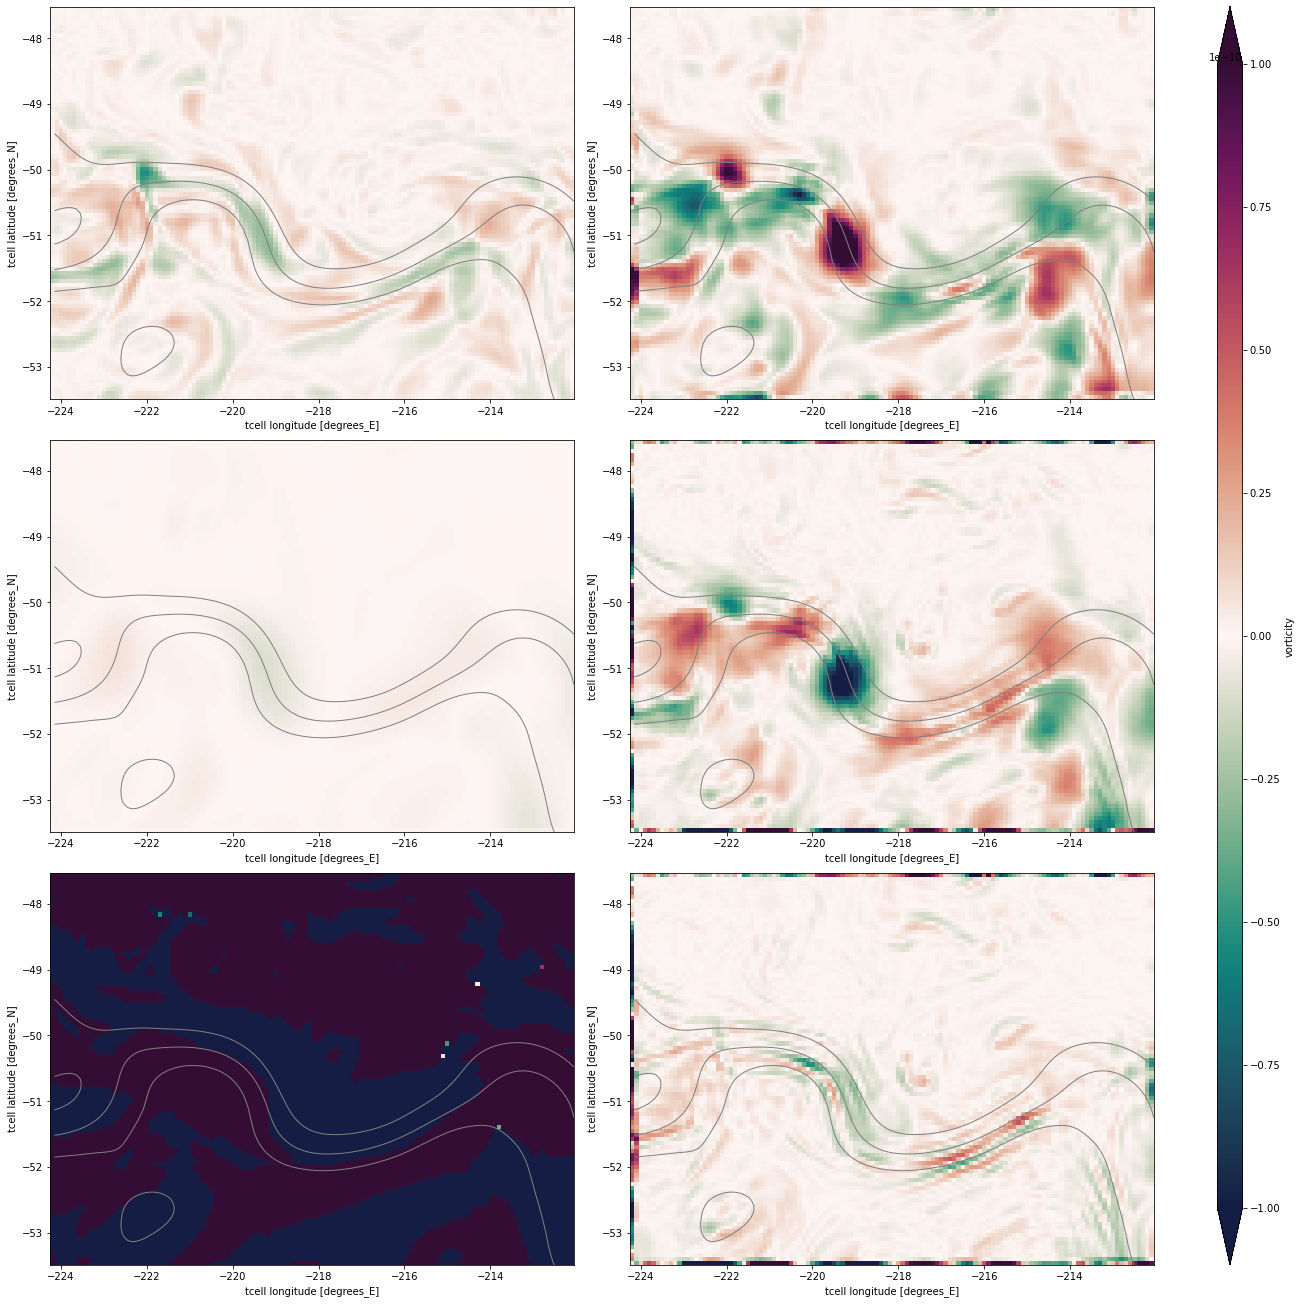

In [46]:
core_contour = -0.4
sl_contours = [core_contour-0.2, core_contour, core_contour+0.2]
depth = 200

cmap = cmo.cm.curl
vmin, vmax = -1e-10, 1e-10
nrows, ncols = 3, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 18), constrained_layout=True)

# vorticity tendency
pcol = qgvb.dzetadt.sel(st_ocean=depth,method='nearest').mean('time').plot(ax=ax[0, 0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, add_labels=False)

# advection of relative vorticity
qgvb.ugradzeta.sel(st_ocean=depth,method='nearest').mean('time').plot(ax=ax[0, 1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

# advection of planetary vorticity
qgvb.betav.sel(st_ocean=depth,method='nearest').mean('time').plot(ax=ax[1, 0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

# vortex stretching
qgvb.fdwdz.sel(st_ocean=depth,method='nearest').mean('time').plot(ax=ax[1, 1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

# wind stress
stress_curl(wind_stress, grid, stress_names=('tau_x', 'tau_y')).plot(ax=ax[2, 0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

# residual
(qgvb.dzetadt + qgvb.ugradzeta + qgvb.betav + qgvb.fdwdz).sel(st_ocean=depth,method='nearest').mean('time').plot(ax=ax[2, 1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols

    # if (r, c) != (0, 1):
    cont = sl_lim.sel(time=flex_period).mean('time').plot.contour(
        ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray')

cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
cbar.ax.set_ylabel('vorticity')

## Vorticity budget at depth

NameError: name 'fs_large' is not defined

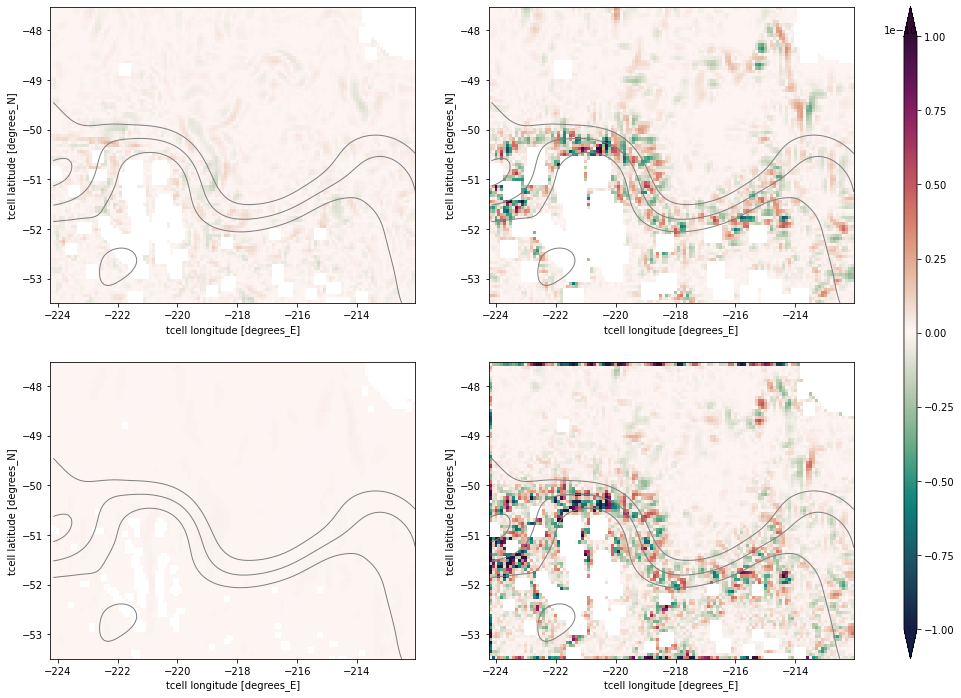

In [36]:
core_contour = -0.4
sl_contours = [core_contour-0.2, core_contour, core_contour+0.2]
depth = 2500

cmap = cmo.cm.curl
vmin, vmax = -1e-10, 1e-10
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12))

# vorticity tendency
pcol = qgvb.dzetadt.sel(st_ocean=depth,method='nearest').mean('time').plot(ax=ax[0, 0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

# advection of relative vorticity
qgvb.ugradzeta.sel(st_ocean=depth,method='nearest').mean('time').plot(ax=ax[0, 1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

# advection of planetary vorticity
qgvb.betav.sel(st_ocean=depth,method='nearest').mean('time').plot(ax=ax[1, 0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

# vortex stretching
qgvb.fdwdz.sel(st_ocean=depth,method='nearest').mean('time').plot(ax=ax[1, 1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

for iax in range(ax.size):
    r, c = iax // ncols, iax % ncols

    # if (r, c) != (0, 1):
    cont = sl_lim.sel(time=flex_period).mean('time').plot.contour(
        ax=ax[r, c], levels=sl_contours, linestyles='solid', linewidths=1, colors='gray')

cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
cbar.ax.set_ylabel('vorticity', fontsize=fs_large)


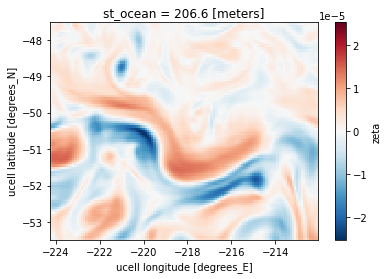

In [26]:
# ((tau_xlim**2 + tau_ylim**2)**(1/2)).plot()
# wind_stress.tau_x.plot(ax=ax[0,0])

In [63]:
# # tau_ylim.plot()

# nrows, ncols = 3, 2
# fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 18), constrained_layout=True)

# wind_stress.tau_x.plot(ax=ax[0, 0])
# wind_stress.tau_y.plot(ax=ax[0, 1])

# vel.u.sel(st_ocean=200, method='nearest').mean('time').plot(ax=ax[1, 0])
# vel.v.sel(st_ocean=200, method='nearest').mean('time').plot(ax=ax[1, 1])

# stress_curl(wind_stress, grid, stress_names=('tau_x', 'tau_y')).plot(ax=ax[2, 0])
# vel.zeta.sel(st_ocean=0, method='nearest').mean('time').plot(ax=ax[2, 1])


#TODO:
- calculate bottom pressure torque as fw_b (best estimate with daily output), explain anologies with other forms of BPT calculations in manuscript
- calculate vertical integrated vortex stretching (total vortex stretching)
- calculate vertical integral of vorticity tendency advection or relative and planetary vorticity
- 

In [45]:
dzetadt = vorticity_tendency(vel)
ugradzeta = adv_relative_vorticity(vel, grid)
betav = adv_planetary_vorticity(vel, grid)
fdwdz = -vortex_stretching(vel, grid, delta_names=('dxt', 'dyt'))

qgvb = xr.merge([dzetadt, ugradzeta, betav, fdwdz])

## Vertically integrated vorticity balance

### Bottom pressure torque

$$J(A,B) = \frac{\partial A}{\partial x}\frac{\partial B}{\partial y} - \frac{\partial A}{\partial y}\frac{\partial B}{\partial x}$$

"bottom pressure torque can be interpreted in terms of the geostrophic flow at the sea floor"

$$\rho f {\bf u_b} = ({\bf k} \times {\bf \nabla} p)_b$$
$$ \rho f {\bf u_b} \cdot {\bf \nabla}\eta_b = J(p_b, \eta_b)$$ 

"As there is no flow through the seafloor, any horizontal flow toward an isobath must be accompanied by a vertical flow"

$$w_b = -{\bf u_b} \cdot {\bf \nabla}\eta_b$$

such that the BPT can be defined as

$$\rho f w_b = -J(p_b, \eta_b)$$

"When friction is allowed, this becomes a condition at the top of the bottom Ekman layer, and the effect of bottom stress curl must also be allowed."

### Firing 2016: vortex stretching due to flow over topography
$$fw_b=f{\bf u_b}\cdot\nabla_h\eta_b$$

In [47]:
# fig,ax=plt.subplots(figsize=(18,8))
# ht_lim.plot.contour(ax=ax, cmap=plt.cm.binary)
# Vgeos.plot(ax=ax, cmap=cmo.cm.speed, vmin=0, vmax=1,zorder=-1)

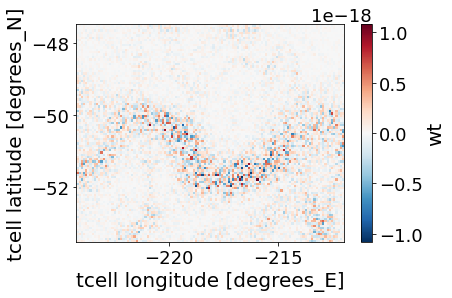

In [141]:
wt_lim.isel(sw_ocean=kmt_lim).sel(time=monthly_mean).mean('time').plot()

### Vertical component of the curl of the horizontal frictional forces

$$ \nabla_H \times \tau_w = \frac{\partial \tau_{w,y}}{\partial x} - \frac{\partial \tau_{w,x}}{\partial y}$$

In [20]:
# curl of the wind and bottom stress

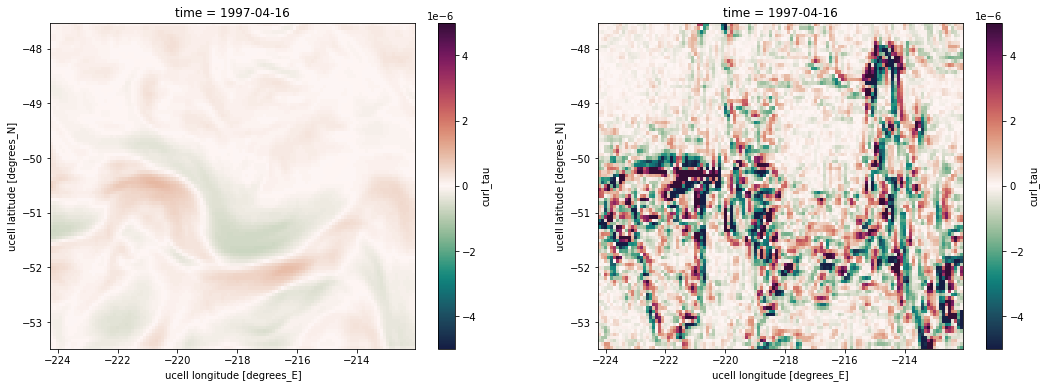

In [21]:
cmap = cmo.cm.curl
vmin, vmax = -5e-6, 5e-6
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
stress_curl(wind_stress, grid, stress_names=('tau_x', 'tau_y')).plot(ax=ax[0], cmap=cmap, vmin=-5e-6, vmax=5e-6)
stress_curl(bottom_stress, grid, stress_names=('bmf_u', 'bmf_v')).plot(ax=ax[1], cmap=cmap, vmin=vmin, vmax=vmax, extend='neither')

<xarray.DataArray (time: 16, yu_ocean: 94, xu_ocean: 122)>
dask.array<sum-aggregate, shape=(16, 94, 122), dtype=float32, chunksize=(1, 62, 118), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1997-04-10T12:00:00 ... 1997-04-25T12:00:00
  * yu_ocean  (yu_ocean) float64 -53.46 -53.4 -53.34 ... -47.69 -47.62 -47.56
  * xu_ocean  (xu_ocean) float64 -224.2 -224.1 -224.0 ... -212.3 -212.2 -212.1

In [ ]:
fcor,_ = xr.broadcast(f(ds.yu_ocean), ds.xu_ocean)
div_hu = horizontal_divergence(ds, grid, delta_names=('dxt', 'dyt'))

In [ ]:
total_fdwdz = fcor * grid.integrate(-div_hu, 'S')
total_betav = grid.integrate(betav, 'S')
total_dzetadt = grid.integrate(dzetadt, 'S')
total_ugradzeta = grid.integrate(ugradzeta, 'S')


In [ ]:
wind_stress_curl = (1/1025) * stress_curl(wind_stress, grid, stress_names=('tau_x', 'tau_y'))
bottom_stress_curl = -(1/1025) * stress_curl(bottom_stress, grid, stress_names=('bmf_u', 'bmf_v'))

In [ ]:
cmap = cmo.cm.curl
vmin, vmax = -1e-7, 1e-7
nrows, ncols = 3, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 18), constrained_layout=True)


total_dzetadt.mean('time').plot(ax=ax[0, 0], vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
total_ugradzeta.mean('time').plot(ax=ax[0, 1], vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)

total_betav.mean('time').plot(ax=ax[1, 0], vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
total_fdwdz.mean('time').plot(ax=ax[1, 1], vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)

wind_stress_curl.plot(ax=ax[2, 0], vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)
bottom_stress_curl.plot(ax=ax[2, 1], vmin=vmin, vmax=vmax, cmap=cmap, add_colorbar=False)

cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
cbar.ax.set_ylabel('vorticity', fontsize=fs_large)

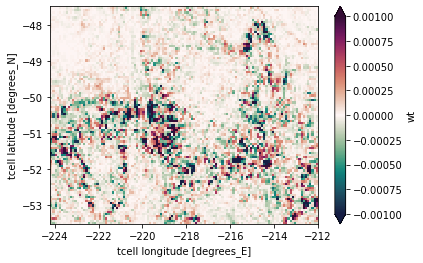

In [77]:
last_cell = kmt_lim.copy()
last_cell.values = last_cell.values.astype(int) - 2
ds.wt.isel(sw_ocean=last_cell).mean('time').plot(vmin=-1e-3, vmax=1e-3, cmap=cmo.cm.curl)

## Bottom pressure torque

In [41]:
bpt = bottom_pressure_torque(ds, grid)
last_cell = kmt_lim.copy()
last_cell.values = last_cell.values.astype(int) - 2

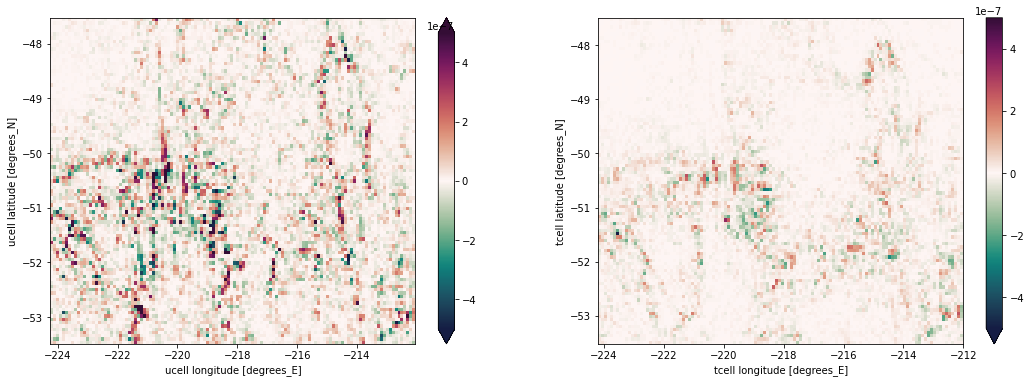

In [44]:
fig, ax = plt.subplots(ncols=2, figsize=(18,6))
bpt.mean('time').plot(ax=ax[0], cmap=cmo.cm.curl, vmin=-5e-7, vmax=5e-7)

fcor_t,_ = xr.broadcast(f(ds.yt_ocean), ds.xt_ocean)
(fcor_t*ds.wt.isel(sw_ocean=last_cell).mean('time')).plot(ax=ax[1], cmap=cmo.cm.curl, vmin=-5e-7, vmax=5e-7)

In [97]:
xr.merge([ds, fdwdz])

<xarray.Dataset>
Dimensions:    (xt_ocean: 122, yt_ocean: 95, xu_ocean: 122, yu_ocean: 94,
                time: 16, st_ocean: 75, sw_ocean: 75)
Coordinates:
  * xt_ocean   (xt_ocean) float64 -224.1 -224.0 -223.9 ... -212.2 -212.1 -212.0
  * yt_ocean   (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
  * xu_ocean   (xu_ocean) float64 -224.2 -224.1 -224.0 ... -212.3 -212.2 -212.1
  * yu_ocean   (yu_ocean) float64 -53.46 -53.4 -53.34 ... -47.69 -47.62 -47.56
  * time       (time) datetime64[ns] 1997-04-10T12:00:00 ... 1997-04-25T12:00:00
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * sw_ocean   (sw_ocean) float64 1.083 2.279 3.601 ... 5.61e+03 5.809e+03
Data variables: (12/13)
    dxt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    dxu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    dyu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    area_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    area_u     (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    ...         ...
    sea_level  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 95, 122), meta=np.ndarray>
    u          (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 19, 66, 122), meta=np.ndarray>
    v          (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 19, 66, 122), meta=np.ndarray>
    wt         (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 19, 66, 122), meta=np.ndarray>
    zeta       (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 19, 1, 1), meta=np.ndarray>
    fdwdz      (yu_ocean, xu_ocean, time, st_ocean) float64 dask.array<chunksize=(1, 1, 1, 19), meta=np.ndarray>
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-06-09
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Source code: https://github.com/COSIMA/access-om2 License:...

In [108]:
ds

<xarray.Dataset>
Dimensions:    (xt_ocean: 122, yt_ocean: 95, xu_ocean: 122, yu_ocean: 94,
                time: 16, st_ocean: 75, sw_ocean: 75)
Coordinates:
  * xt_ocean   (xt_ocean) float64 -224.1 -224.0 -223.9 ... -212.2 -212.1 -212.0
  * yt_ocean   (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
  * xu_ocean   (xu_ocean) float64 -224.2 -224.1 -224.0 ... -212.3 -212.2 -212.1
  * yu_ocean   (yu_ocean) float64 -53.46 -53.4 -53.34 ... -47.69 -47.62 -47.56
  * time       (time) datetime64[ns] 1997-04-10T12:00:00 ... 1997-04-25T12:00:00
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * sw_ocean   (sw_ocean) float64 1.083 2.279 3.601 ... 5.61e+03 5.809e+03
Data variables:
    dxt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    dxu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    dyu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    area_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    area_u     (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    ht         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    sea_level  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 95, 122), meta=np.ndarray>
    u          (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 19, 66, 122), meta=np.ndarray>
    v          (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 19, 66, 122), meta=np.ndarray>
    wt         (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 19, 66, 122), meta=np.ndarray>
    zeta       (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 19, 1, 1), meta=np.ndarray>
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-06-09
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Source code: https://github.com/COSIMA/access-om2 License:...

In [116]:
ds

<xarray.Dataset>
Dimensions:    (time: 19, xt_ocean: 122, yt_ocean: 95, st_ocean: 75,
                xu_ocean: 122, yu_ocean: 94, sw_ocean: 75)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-16T12:00:00 ... 1997-04-25T12:00:00
  * xt_ocean   (xt_ocean) float64 -224.1 -224.0 -223.9 ... -212.2 -212.1 -212.0
  * yt_ocean   (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * xu_ocean   (xu_ocean) float64 -224.2 -224.1 -224.0 ... -212.3 -212.2 -212.1
  * yu_ocean   (yu_ocean) float64 -53.46 -53.4 -53.34 ... -47.69 -47.62 -47.56
  * sw_ocean   (sw_ocean) float64 1.083 2.279 3.601 ... 5.61e+03 5.809e+03
Data variables:
    dxt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    dst        (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 19, 66, 122), meta=np.ndarray>
    dxu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    dyu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    area_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    area_u     (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 122), meta=np.ndarray>
    ht         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 122), meta=np.ndarray>
    sea_level  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(4, 95, 122), meta=np.ndarray>
    u          (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(4, 19, 66, 122), meta=np.ndarray>
    v          (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(4, 19, 66, 122), meta=np.ndarray>
    wt         (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(4, 19, 66, 122), meta=np.ndarray>
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-06-09
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Source code: https://github.com/COSIMA/access-om2 License:...

In [117]:
grid.integrate(xr.merge([ds, fdwdz]).fdwdz, 'S')

KeyError: "Unable to find any combinations of metrics for array dims {'st_ocean', 'xu_ocean', 'time', 'yu_ocean'} and axes 'S'"

array([1.2993813e-05, 1.4305115e-05, 1.5854836e-05, 1.7642975e-05,
       1.9431114e-05, 2.1338463e-05, 2.3722649e-05, 2.6226044e-05,
       2.8848648e-05, 3.2186508e-05, 3.5285950e-05, 3.8862228e-05,
       4.2915344e-05, 4.7683716e-05, 5.2452087e-05, 5.8174133e-05,
       6.4373016e-05, 7.1048737e-05, 7.8201294e-05, 8.6784363e-05,
       9.5844269e-05, 1.0585785e-04, 1.1730194e-04, 1.2969971e-04,
       1.4305115e-04, 1.5735626e-04, 1.7452240e-04, 1.9264221e-04,
       2.1171570e-04, 2.3460388e-04, 2.5939941e-04, 2.8610229e-04,
       3.1661987e-04, 3.4904480e-04, 3.8337708e-04, 4.2343140e-04,
       4.6539307e-04, 5.1498413e-04, 5.6457520e-04, 6.1798096e-04,
       6.7901611e-04, 7.4386597e-04, 8.1634521e-04, 8.8500977e-04,
       9.6130371e-04, 1.0452271e-03, 1.1291504e-03, 1.2207031e-03,
       1.3122559e-03, 1.3961792e-03, 1.4877319e-03, 1.5716553e-03,
       1.6632080e-03, 1.7395020e-03, 1.8157959e-03, 1.8920898e-03,
       1.9531250e-03, 2.0141602e-03, 2.0751953e-03, 2.1209717e

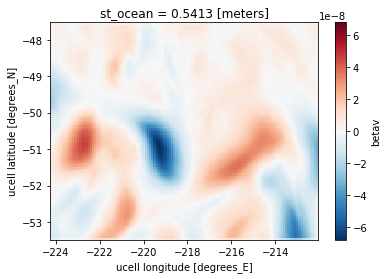

In [75]:
adv_planetary_vorticity(ds, grid)[0].isel(st_ocean=0).mean('time').plot()

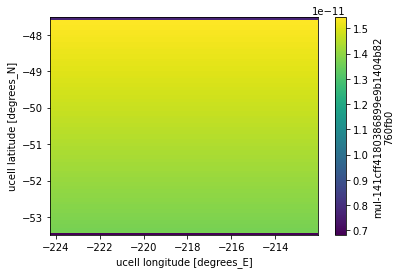

In [87]:
adv_planetary_vorticity(ds, grid)[1].plot()

In [ ]:
betav, beta = adv_planetary_vorticity(ds, grid)

# fig, ax = plt.subplots(ncols=2, figsize=(18,6))
# betav.sel(st_ocean=200,method='nearest').mean('time').plot(ax=ax[0], cmap=cmo.cm.curl, vmin=-1e-8, vmax=1e-8)
# betav.sel(st_ocean=2500,method='nearest').mean('time').plot(ax=ax[1], cmap=cmo.cm.curl, vmin=-1e-10, vmax=1e-10)

### Bottom pressure torque as explained in Jackson et al., 2006

In [120]:
last_cell = kmt_lim.copy()
last_cell.values = last_cell.values.astype(int) - 1
sec_last_cell = kmt_lim.copy()
sec_last_cell.values = sec_last_cell.values.astype(int) - 2
thrd_last_cell = kmt_lim.copy()
thrd_last_cell.values = thrd_last_cell.values.astype(int) - 5

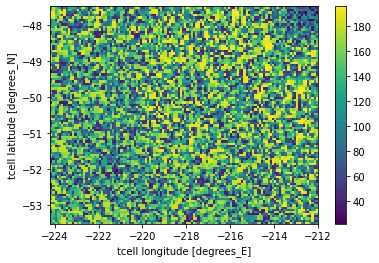

In [121]:
(ds.ht - ds.wt.isel(sw_ocean=last_cell).sw_ocean).plot()

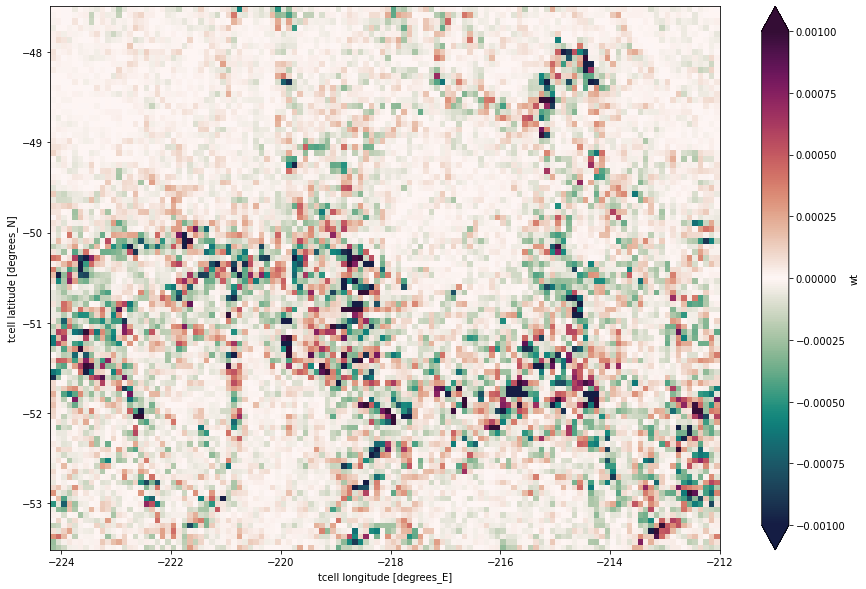

In [125]:
# fwb
f=-1e-4
rho = 1025
bpt = ds.wt.isel(sw_ocean=last_cell)

cmap=cmo.cm.curl
bpt.mean('time').plot(size=10, cmap=cmap, vmin=-1e-3, vmax=1e-3)

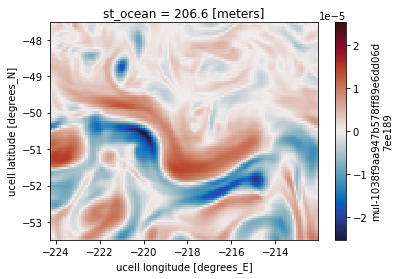

In [13]:
# velocity magnitude
V_lim = (u_lim**2 + v_lim**2)**(1/2)
V_lim.name = 'V'

# bottom velocities
botu_lim = u_lim.isel(st_ocean=kmu_lim)
botv_lim = v_lim.isel(st_ocean=kmu_lim)
botV_lim = V_lim.isel(st_ocean=kmu_lim)

bot_vel = xr.merge([botu_lim, botv_lim, botV_lim])

In [14]:
time_sel = slice('1999-05-25', '1999-05-31')


<a list of 10 text.Text objects>

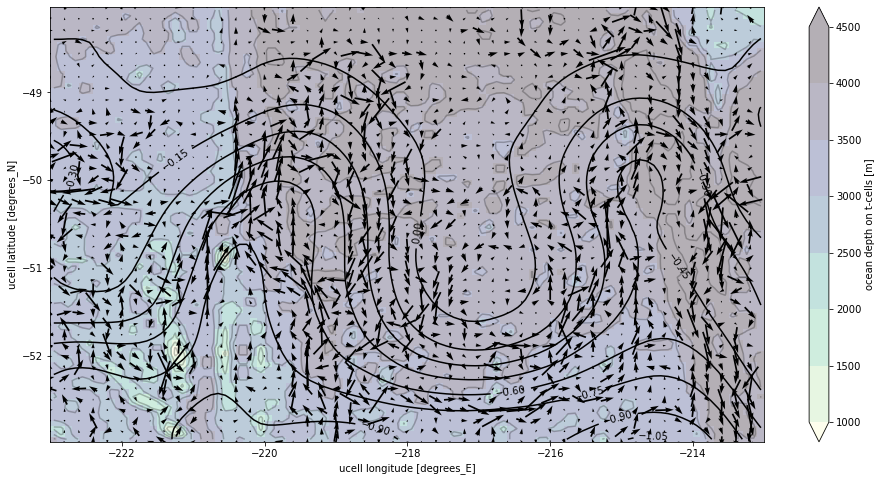

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))

bathy_levels = np.linspace(1000, 4500, 8)
cmap = cmo.cm.deep
norm = mcolors.BoundaryNorm(bathy_levels, ncolors=9)

pcol = ht_lim.plot(ax=ax, cmap=cmap, norm=norm, alpha=0.35)#, cbar_kwargs={'orientation': 'horizontal'})
ct = ht_lim.plot.contour(ax=ax, levels=bathy_levels, colors='k', alpha=0.25)
# ct.clabel([2000, 3000, 4000, 4500])

# skip=(slice(None,None,2),slice(None,None,2))
# ax.quiver(bot_vel.u[skip].xu_ocean, bot_vel.u[skip].yu_ocean, bot_vel.u[skip], bot_vel.v[skip])
bot_vel.sel(time=time_sel).mean('time').sel(xu_ocean=slice(None,None,2), yu_ocean=slice(None,None,2)).plot.quiver(x='xu_ocean', y='yu_ocean', u='u', v='v')

ct = ax.contour(sl_lim.xt_ocean, sl_lim.yt_ocean, sl_lim.sel(time=time_sel).mean('time'),
                colors='k', linestyles='solid')
ax.clabel(ct)
# cbar = fig.colorbar(pcol, extend='both')

In [12]:
## Vertical resolution

Text(0.5, 0, 'Vertical resolution ($dz$)')

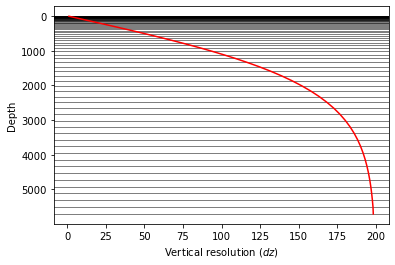

In [16]:
fig, ax = plt.subplots()
for z in u.st_ocean:
    ax.axhline(z, color='k', lw=0.5)
ax.plot(np.gradient(u.st_ocean), u.st_ocean, 'r')
ax.invert_yaxis()
ax.set_ylabel('Depth')
ax.set_xlabel(r'Vertical resolution ($dz$)')